# Piccola cosmologia su portatile 

Benvenute e benvenuti al laboratorio di cosmologia! 

Nelle celle di questo notebook esploreremo alcune funzionalità di base ed applicazioni di alcun pacchetti di python sviluppati dai cosmologi per le proprie ricerche. 
I pacchetti in questione sono a tutti gli effetti delle "calcolatrici scientifiche": così come la nostra calcolatrice può estrarre radici e risolvere equazioni algebriche di base premendo il pulsante uguale, noi, al prezzo di fornire alcune istruzioni in più (dare istruzioni al computer è il significato ultimo di programmare) potremo sfruttare le potenzialità di Python per giocare con (o all') universo.

In particolare, esploreremo le seguenti funzionalità:

- Generazione di uno spettro di potenza con l'halo model
- Generazione di una simulazione lognormale con l'halo model
- Discussione, tramite il Boltzmann solver $\texttt{CAMB}$, del perché lo spettro di potenza ha la forma che ha: in particolare l'evoluzione delle scale con il redshift, l'evoluzione per diversi tipi di perturbazioni, di materia o dei fotoni...
- "Pseudo" fit delle oscillazioni acustiche barioniche dello spettro di potenza, per imparare i rudimenti dell'inferenza bayesiana e in generale come i fisici stabiliscono l'affidabilità e la "verità" delle loro misure. 

Per contatti: andrearubiola.97@gmail.com

## Introduzione

La "calcolatrice scientifica" va inizializzata. Importeremo quindi per prima cosa dei pacchetti di utilità generale che consentono di fare i calcoli fondamentali per ogni fisico, nonché eponimi dei primi esami che sempre si danno all'università: algebra (con $\texttt{numpy}$) e analisi $\texttt{scipy}$, che consente anche applicazioni di statistica, interpolazione e ottimizzazione (ricerca di massimi e minimi) di funzioni.  
In aggiunta, $\texttt{Matplotlib}$ consente di plottare grafici ed in generale gestire la grafica dei nostri risultati. 

In [1]:
######## Utilità generali #############################

import numpy as np # algebra e manipolazione di vettori (array) di dati
import scipy # analisi e manipolazione di funzioni (integrali, derivate, equazioni, interpolazioni...)

######### Grafica #####################################

%matplotlib inline
import matplotlib.pyplot as plt # per la grafica

    
# Latex: per impostare la grafica "come se fosse un vero articolo scientifico"
font = {'size'   : 45, 'family':'STIXGeneral'}
axislabelfontsize='x-large'
plt.rc('text', usetex=False)

#plt.rc('font', **font)
plt.rcParams['text.usetex'] = True
np.set_printoptions(precision=3,linewidth=200,suppress=False)

# 0. Perché i cosmologi lavorano nello spazio di Fourier 

La ricetta generale per fare cosmologia si può ridurre ai seguenti ingredienti:

- **Quantità fisiche** che vengono propagate nel tempo e nello spazio e fatte interagire secondo le equazioni della Relatività Generale, in modo da calcolare:
    - L'espansione dell'universo omogeneo e isotropo ('background'), in funzione del parametro di Hubble $H_{0}$, dei parametri di densità delle componenti di materia $\Omega_{materia \ oscura}$, $\Omega_{barioni}$,$\Omega_{fotoni}$, $\Omega_{neutrini}$, energia oscura  $\Omega_{\Lambda}$, e curvatura $ \Omega_{K}$
    - La dinamica delle perturbazioni delle varie componenti di materia, le loro interazioni, l'effetto che hanno sui potenziali gravitazionali, sul campo di densità, velocità, pressione, onde gravitazionali e altri campi che si possono aggiungere a seconda del modello teorico (ad esempio, campi magnetici).
- **Quantità statistiche** ("summary statistics", correlatori) come valori medi (1-point statistics), varianze (2-point statistics, come lo spettro di potenza), bispettri (3-point statistics) che misurano la quantità di "struttura" ad una scala dimensionale in termini della correlazione tra i vari punti rispetto all'omogeneità ed isotropia dello sfondo. 

Le misure sulla struttura a grandi scale (large scale structure, LSS) o sulla radiazione cosmica di fondo (cosmic microwave background, CMB) sono in gran parte statistiche: queste quantità ci consentono di rappresentare, interpretare e fittare i dati per estrarne i parametri che intendiamo misurare. 
Esistono d'altra parte anche osservabili non statistiche funzione di quantità fisiche di interesse, gran parte delle quali rientrano nelle cosiddette "misure dirette": in particolare, è possibile misurare la costante di Hubble in funzione del redshift, ad  partire dalla luminosità intrinseca delle supernove Ia, o, tramite misure di lente gravitazionale forte, "pesare" gli ammassi di galassie e stabilire il valore del parametro $\Omega_{materia}$. Più misure indipendenti abbiamo a disposizione, meglio è, perché aumenta il nostro **potere vincolante** (constraining power) sul modello, che ci consente di valutarne accuratezza (vicinanza al valore vero di una misura) e precisione (piccole dimensioni delle incertezze). 


### Ancora non ci hai detto a che cosa serve lo spazio di Fourier...


Un attimo, miei venticinque lettori!

Ora, le quantità statistiche possono essere calcolate nello spazio reale (delle posizioni, delle velocità...), cioè direttamente dai dati osservati. 
Ad esempio, la funzione di correlazione a due punti è la corrispondente ("trasformata") nello spazio reale dello spettro di potenza ed è un concetto abbastanza intuitivo: è l'eccesso di probabilità di trovare coppie di oggetti -- in particolare, galassie --  separati da una certa distanza **$\mathbf{x}_{1,2}$** rispetto ad una distribuzione uniforme di materia in cui tutti gli oggetti sono "puntini" equidistanziati ("rumore poissoniano"). 

Tuttavia, il linguaggio nello spazio di Fourier è più diffuso, ed è il "frullatore" che amalgama i nostri ingredienti nella pratica quotidiana della ricerca in cosmologia. 
Il motivo fondamentale è che nello spazio di Fourier, i segnali complessi possono essere scomposti in **somme di segnali semplici e fondamentali**, con ciascun addendo indipendente dall'altro, così come il timbro di uno strumento musicale (il motivo per cui distinguiamo un flauto da un pianoforte anche quando suonano la stessa nota) può essere scomposto in sovrapposizione di frequenze. Questo porta ad una notevole semplificazione matematica dei calcoli, perché si può interpretare la dinamica delle perturbazioni dell'universo in questo modo:


- L'universo a livello di background è un "mare" di densità uniforme, senza increspature, che si espande.
- L'inflazione avvenuta subito dopo il Big Bang getta i "semi" di alcune increspature molto piccole, le "perturbazioni"; queste perturbazioni interessano in modo diverso i vari fluidi cosmologici. La gravità -- e gli effetti termodinamici per barioni e fotoni -- le fa interagire e crescere. 
- Tali increspature si possono scomporre in onde di frequenza diversa, non onde sonore, ma nello spazio. In questo senso, più che pensare al timbro di uno strumento, è opportuno pensare ad un paesaggio: la cui "orografia" è una sovrapposizione di onde "lunghe" (modi a grande scala, i cui picchi tracciano catene montuose, valli profonde o depressioni, i vuoti, a seconda che si sia nei massimi o minimi, sovra o sottodensità), mentre le onde con a piccola scala determinando le varie creste o piccole colline  (modi a piccola scala)
Data una scala di lunghezza $L$ (solitamente misurata in Megaparsec, la dimensione caratteristica degli ammassi, circa trenta volte più grande delle dimensioni della via Lattea, il cui raggio è 30 kiloparsec), un modo nello spazio di Fourier è inversamente proporzionale alla scala ed è solitamente indicata con la lettera $k = \dfrac{2 \pi}{L} $. Modi piccoli corrispondono a grandi scale e strutture di grandi dimensioni, e viceversa. Le strutture si formano nei picchi di sovradensità, dove i potenziali gravitazionali sono più intensi, come illustrato dall'immagine qui sotto:


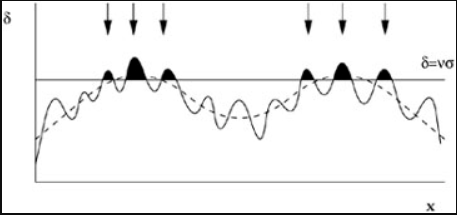

Lo stesso ragionamento si può fare per un'immagine in due dimensioni, pensate per esempio al volto di un essere umano: 
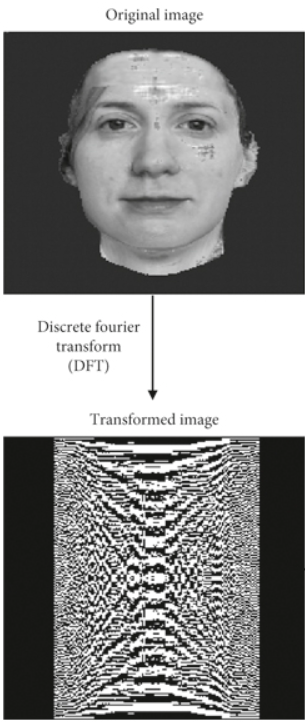





Si può pensare che gli occhi, il naso e le orecchie siano "picchi" di una stessa onda di densità, così come le labbra sono invece l'effetto della sovrapposizione di più onde, che in parte si sommano facendo interferenza distruttiva, determinando solo una "struttura locale". 
Lo stesso ragionamento si può fare considerando i modi che si propagano in direzione verticale, dal mento alla fronte. 
Ecco che allora, raccogliendo tutti i modi che caratterizzano un'immagine $-$ per il cosmologo, la mappa **tridimensionale** della densità dell'universo $-$ si può lavorare nello spazio di Fourier per scomporre la complessità della ragnatela cosmica, e ricondurla poi alle sue proprietà statistiche. L'idea generale è "contare" l'abbondanza di modi per ciascun valore di scala, un po' come di un Paese del mondo possiamo raggruppare le città in un istogramma in base alla loro estensione od il numero di abitanti che hanno${^1}$, in modo più preciso, l'informazione minima che più ci interessa e la correlazione tra due punti qualunque della struttura a grande scala, cioè la statistica a due punti che chiamiamo **spettro di potenza**; non è l'unica, ma è la più diffusa e studiata, anche se c'è molta attenzione da parte dei ricercatori per estensioni e alternative. Più correlazione c'è, più ci si può aspettare di avere struttura organizzata.

$^{1}$ A rigore, quest'analogia è più appropriata per la *funzione di massa* degli aloni, non per lo spettro di potenza, che misura la varianza, cioè la deviazione dalla densità media, più che un valore puntuale di massa o estensione, scala per scala, ma credo che sia sufficiente per rendere l'idea, pur nella sua inaccuratezza. 


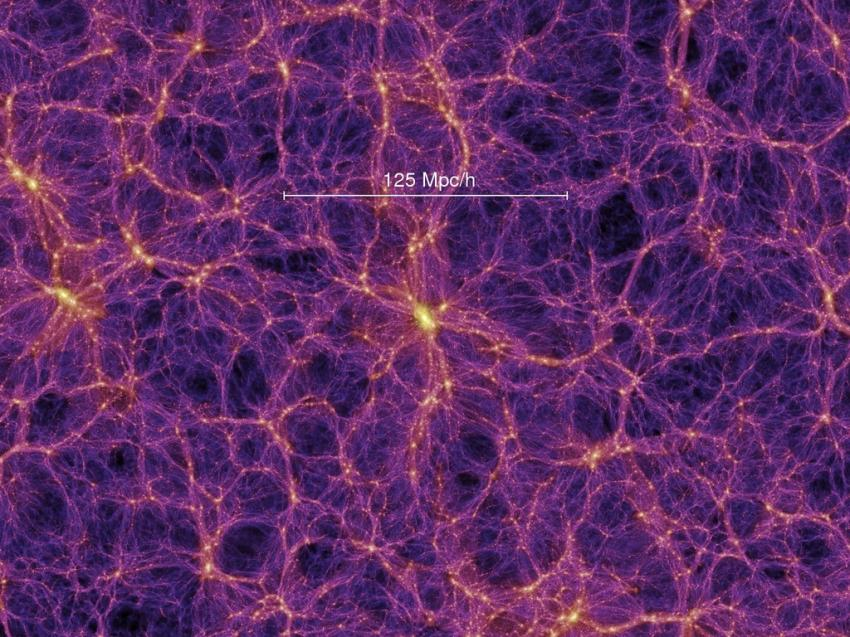

## 1.  Generare simulazioni lognormali con l'halo model 

I pacchetti $\texttt{halomod}$, $\texttt{hmf}$ consentono di generare lo "spettro di potenza" delle strutture cosmiche a partire dall'halo model. Questo modello assume che tutta la materia (materia oscura e barioni) sia contenuta dentro aloni di materia oscura (non esistono quindi né vuoti né filamenti), e che le galassie a loro volta siano delle "palline" che occupano tali aloni in misura diversa a seconda che siano centrali nell'ammasso o satelliti, secondo modelli chiamati halo occupation distributions (HOD). 

Rispetto allo spettro di potenza che si ottiene dalle equazioni della relatività generale (almeno al primo ordine perturbativo), l'halo model è automaticamente $\textbf{non lineare}$, ovvero tiene conto di come i processi di aggregazione delle galassie e degli ammassi a piccola scala (grandi k), determinino un eccesso di correlazione -- altrimenti detto, non è sufficiente descrivere una regione come sovrapposizione, cioè somma, di modi, occorre tenere conto anche del prodotto tra le varie onde di densità -- che si traduce in una "spalla" dello spettro di potenza a grande $k$.

Lo spettro dell'halo model si può definire in questo modo:

$$ P_{hm,totale}(k,z) = P_{hm, 1 halo}(k,z) + P_{hm, 2halo}(k,z)$$
Dove:
- $P_{hm, 1 halo}(k,z)$ è il termine "1 halo", che tiene conto degli effetti **piccole scale** (grandi  *k*). A piccoli *k* è molto piccolo e non conta più. Questo termine tiene conto della correlazione tra **oggetti che appartengono allo stesso alone *posti in posizione diversa***, per questo si chiama 1halo. Il suo comportamento si può comprendere pensando in questo modo: a piccole scale, gli oggetti all'interno di uno stesso alone sono verosimilmente molto correlati, perché si sono formati nella stessa sovradensità (ad esempio, galassie in un ammasso, o una galassia e le sue satelliti); come tale, è in grado di riprodurre la gran parte della non linearità dello spettro di potenza, derivante proprio dalla "sovraaccumulazione" di strutture all'interno di un oggetto legato gravitazionalmente. Se cerco correlazioni a grandi scale, cioè tra oggetti che appartengono a uno stesso alone molto grande, la correlazione si riduce, tendo a vedere una distribuzione uniforme di oggetti tutti attorno, cioè un rumore poissoniano che si traduce in uno spettro piatto (forma un "plateau"). La caratteristica gobba dello spettro non lineare è data dall'inserzione di questo plateau (che conta per la presenza di più struttura) e da un certo cambio di pendenza dello spettro, che comunque riprende a decrescere per via del generale "processamento" a piccole scale dato dai vari processi di soppressione delle strutture dato dai processi dissipativi contenuti anche nella teoria lineare. 
$\phantom{a
a
a
a}$
- $P_{hm, 2 halo}(k,z)$ è il termine "2 halo", che tiene conto delle **grandi  scale** (piccoli *k*). A grandi *k* diventa molto piccolo e non conta più. Questo termine tiene conto della distribuzione e della correlazione tra **oggetti che appartengono a *coppie* aloni distinti e con centri distinti**, per questo si chiama 2halo. Si può immaginare che la correlazione tra aloni distinti corrisponda a perturbazioni di grande estensione, i cui picchi sono molto distanti, ma tuttavia appartenenti alla stessa onda di densità. Questa è la stessa informazione contenuta nello spettro di potenza definito dalla teoria lineare, con una decrescità progressiva della correlazione.A grandi scale, l'universo è ancora molto lineare (così come lo è a più alto redshift, notare la doppia dipendenza dello spettro di potenza!) perché la gravità ha determinato meno aggregazione delle strutture, meno effetti di feedback e meno dipendenza dal "prodotto di perturbazioni a scale diverse", o da potenze delle perturbazioni diverse dal grado 1, che è ciò che distingue in generale i termini lineari in fisica dai termini non lineari. Per tutti questi motivi il termini di 2halo seguono sostanzialmente lo spettro lineare "dei libri di testo".

Si tenga conto che c'è poi un importante effetto non lineare, dovuto ai moti delle galassie in caduta nelle strutture cosmiche, chiamato redshift space distorsions (RSD) che l'halo model $\textbf{non}$ è in grado di riprodurre.

In generale, poi, ogni termine di 1halo e 2halo è un integrale sulla massa degli aloni ( = sommo i contributi degli aloni di massa, a partire dalla massa minima, che dipende dalle proprietà della materia oscura, più questa è "fredda", più sono i piccoli gli aloni che si possono formare). Questo perché la materia oscura "fredda" ha un'energia cinetica minore (di qui il suo nome) e tende a sfuggire meno ai potenziali gravitazionali, consentendo quindi la stabilizzazione di aloni potenzialmente fino a $10^{-6} M_{\odot}$ (un milionesimo della massa del sole -- la massa della Terra --, ma molto più rarefatta: un alone di quella massa avrebbe densità di $0.008 M_{\odot}/parsec^3$ e avrebbe un raggio di circa 2 mesi luce. Poiché il sistema solare, fino a Plutone, è grande 5 ore luce, questo vuol dire che l'alone sarebbe circa 240 volte più esteso del sistema solare). La somma si arresta attorno a $10^{18} M_{\odot}$, cioè gli aloni che formano gli ammassi di galassie; la massa tipica di una galassia, e dunque del suo alone, è $10^{11} - 10^{12} M_{\odot}$.

La formula di ciascun termine è la seguente: 

$$ P_{\delta,\delta, 1h}(k,z) =  \int_{M_{Min}} ^{M_{Max}} dM \ \frac{dN (M,z)}{dM}  \left (\frac{\rho(k,M,z)}{\bar{\rho}(z)}\right)^2  
    \\
    P_{\delta,\delta, 2h}(k,z) = P_{lin}(k,z) \left [\int_{M_{Min}} ^{M_{Max}} dM  \ \frac{dN (M,z)}{dM} b(M,z) \left(\frac{\rho(k,M,z)}{\bar{\rho}(z)}\right) \right]^2$$

Dove:

- $\frac{dN (M,z)}{dM}$ è la funzione di massa, che conta il numero di aloni nell'universo per ogni unità di massa: tipicamente, ci sono tanti aloni "leggeri" e poi molto pochi sopra le $10^{15} M_{\odot}$: sotto si vede un esempio al variare del redshift: notare come al diminuire del redshift (decrescere verso 0, grafico più rosso) la coda a massa elevata cresce, si sono formati più aloni. 




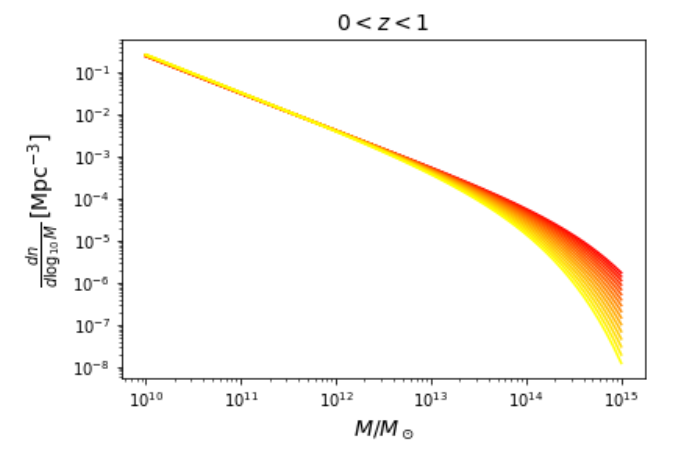

In [2]:
from IPython.display import Image
Image(filename='funzione_massa.png') 

- $b(M,z)$ è il fattore di "bias": ovvero, rispetto alla distribuzione sottostante di materia oscura, un alone deve avere una ulteriore lieve "sovradensità" per formarsi a grande massa (e può anche essere lievemente meno denso a piccola massa). Per questo viene considerato un "fattore di distorsione" (= bias) moltiplicativo. In generale è però molto prossimo ad uno.  Qui sotto si può vedere l'andamento di alcuni modelli al variare della massa, notare che può essere più piccolo di 1.

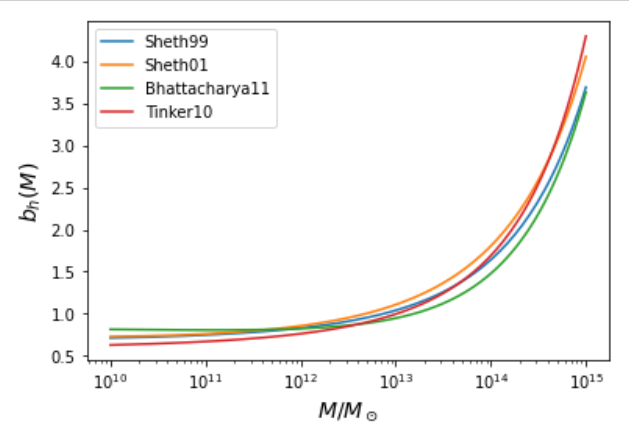

In [3]:
from IPython.display import Image
Image(filename='bias.png') 

- $ \dfrac{\rho(k,M,z)}{\bar{\rho}(z)} $ è il rapporto tra il profilo di densità dell'alone di materia oscura nello spazio (anche se espresso nello spazio di Fourier, in funzione di $k$) e la densità media $\bar{\rho}(z)$ (della materia oscura o dell'universo, a seconda delle definizioni, è una $\textit{normalizzazione}$. I profili di densità ci dicono qual è la struttura tridimensionale degli aloni e dunque il loro potenziale gravitazionale. Sono modellati dai cosmologi a partire dalle simulazioni, combinate con ragionamenti teorici che spingono sovente al limite la teoria perturbativa e cominciano a coinvolgere problemi non lineari (il modello più semplice è il cosiddetto "collasso sferico"), in cui l'astrofisica e la pressione che il gas di barioni esercita comincia a diventare rilevante e molto complicata da modellare, molto di più dei soli effetti di gravità che regolano il comportamento delle particelle di materia oscura (che non esercitano pressione perché non interagiscono se non gravitazionalmente). 
Ce ne sono di diversi tipi: il più semplice e fondamentale è il profilo Navarro-Frenk-White (NFW), che assume che gli aloni siano perfettamente sferici, con un tipico andamento di densità che cresce verso il centro dell'alone, ed una pendenza che cambia ad un raggio caratteristico funzione della massa $r_{s}$, che termina la sua "concentrazione". Più l'alone è di piccola massa, più piccolo è questo raggio, cioè è più "concentrato". Gli aloni a loro volta sono solitamente troncati ad un raggio massimo, il cosiddetto raggio viriale: il nome viene dal fatto che una struttura cosmica è stabile se è in equilibrio viriale, cioé la gravita ne determina l'aggregazione, ma non la fa collassare su se stessa. 

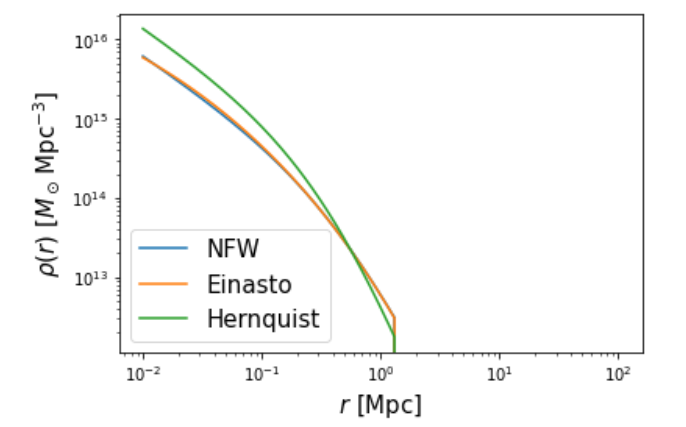

In [4]:
from IPython.display import Image
Image(filename='profilo_densità.png') 

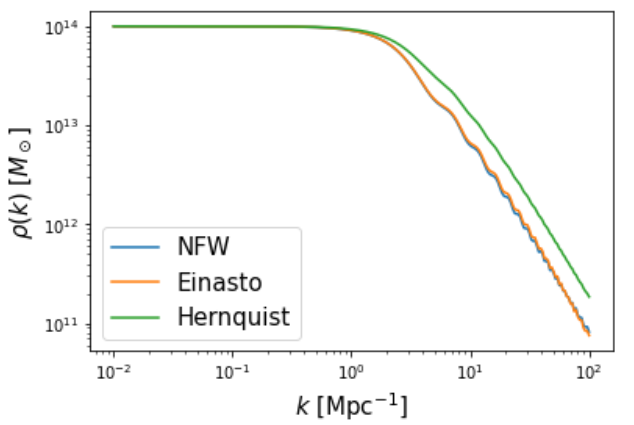

In [5]:
from IPython.display import Image
Image(filename='profili_fourier.png') 

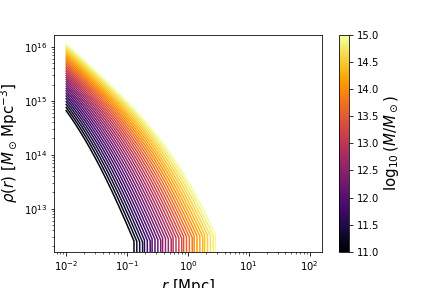

In [6]:
from IPython.display import Image
Image(filename='profili_in_funzione_della_massa.png') 

I due pacchetti $\texttt{halomod}$ e $\texttt{hmf}$ consentono di svogere tutti i calcoli necessari per estrarre gli spettri dall'halo model. Sotto inizializzeremo uno spettro con la ricetta "standard", che combina:

- il bias modellato da Ravi Sheth e Giuseppe Tormen nel 1999, il primo che introduceva molti importanti innovazioni riguardo al trattamento del collasso delle strutture combinando teoria e simulazioni, estendendo la teoria standard di Press e Schechter formulata già negli anni '70 con alcune limitazioni importanti.
- La funzione di massa che Sheth e Tormen hanno sempre ricavato nel 1999.
- Il profilo di densità Navarro-Frenk-White.

Genereremo una serie di spettri e simulazioni associate: il riferimento sarà il modello $\Lambda \rm{CDM}$, ma varieremo il parametro di densità per vedere gli effetti sulle simulazioni che genereremo successivamente. 

In [7]:
# Cosmologia

import halomod
from halomod import DMHaloModel

import hmf
#HMF
from hmf import cosmology
from hmf import density_field
from hmf import Transfer


import powerbox as pbox

/home/andrea/anaconda3/envs/progetto_1/lib/python3.11/site-packages/halomod/halo_exclusion.py:18: UserWarning: Warning: Some Halo-Exclusion models have significant speedup when using Numba
  warnings.warn(


## 1.1 Costruire lo spettro di potenza a partire dall'halo model 

Spunti di riflessione: dipendenza dai parametri cosmologici, funzione di massa, profili degli aloni.

In [8]:
ref_Om_0 = hmf.cosmo.Planck15.Om0

# Generiamo cosmologia di riferimento

hm_ref = DMHaloModel()

redshift = 0.

hm_ref.z = redshift
hm_ref.cosmo_params['OmO'] = ref_Om_0


hm_ref.tracer_profile_model = "NFW" # Primo ingrediente: profilo di densità dell'alone di materia oscura
# Navarro - Frenk - White, lo standard più comune

hm_ref.bias_model = 'ST99'  # Secondo ingrediente, il "bias dell'alone"

hm_ref.hmf_model = 'ST' # Terzo ingrediente: la funzione di massa, quanti (in numero) aloni abbiamo nell'universo per ogni valore di massa dell'alone?

modi_k = np.logspace(-4,3,200) # Generiamo più modi di quelli che halomod normalmente associa agli spettri (pur calcolando il valore dello spettro corrispondente), servirà dopo

# Genero lo spettro di potenza, termini 1halo, 2halo e complessivo

index_1h_max = np.where(hm_ref.power_1h_auto_matter_fnc(modi_k) == np.max(hm_ref.power_1h_auto_matter_fnc(modi_k)))[0] 


max_val_1h = np.max(hm_ref.power_1h_auto_matter_fnc(modi_k)) # valore corrispondente

# Ridefinisco la funzione del 1halo a tratti, in modo che a grandi scale (piccoi k) restituisca un plateau

def pk_1halo_corretto(k,pk):
    
    return np.piecewise(k, [k < modi_k[index_1h_max],k >= modi_k[index_1h_max] ], [lambda x: max_val_1h ,lambda x :pk.power_1h_auto_matter_fnc(x)])



In [9]:
# Generazione della simulazione di riferimento, LCDM

boxlength = 1000
N = 256
#print('Massimo k campionato: ',np.pi * N / boxlength, 'h / Mpc')
#print('Minima scala campionata:', boxlength/N, 'h / Mpc')
# Ovvero, scale più piccole delle scale tipiche degli ammassi di galassie, "vediamo" la non linearità 
# dello spettro di potenza

# Sezione bidimensionale di una simulazione a dato redshift

lnpb_ref_tot = pbox.LogNormalPowerBox(
    N=N,                     # Number of grid-points in the box
    dim=2,                     # 2D box
    pk = lambda k: hm_ref.power_auto_matter_fnc(k), # The power-spectrum
    boxlength = boxlength    ,       # Size of the box (sets the units of k in pk)
    seed = 1010,ensure_physical=True
    # Use the same seed as our LogNormalPowerBox
)

lnpb_ref_2h = pbox.LogNormalPowerBox(
    N=N,                     # Number of grid-points in the box
    dim=2,                     # 2D box
    pk = lambda k: hm_ref.power_2h_auto_matter_fnc(k), # The power-spectrum
    boxlength = boxlength    ,       # Size of the box (sets the units of k in pk)
    seed = 1010,ensure_physical=True
    # Use the same seed as our LogNormalPowerBox
)

lnpb_ref_1h = pbox.LogNormalPowerBox(
    N=N,                     # Number of grid-points in the box
    dim=2,                     # 2D box
    pk = lambda k: pk_1halo_corretto(k,hm_ref), # The power-spectrum
    boxlength = boxlength    ,       # Size of the box (sets the units of k in pk)
    seed = 1010,ensure_physical=True
    # Use the same seed as our LogNormalPowerBox
)

In [10]:
# Inizializziamo l'halo model

In [11]:
modi_k = np.logspace(-4,3,200) # Generiamo più modi di quelli che halomod normalmente associa agli spettri (pur calcolando il valore dello spettro corrispondente), servirà dopo

In [12]:
# Genero lo spettro di potenza, termini 1halo, 2halo e complessivo

index_1h_max = np.where(hm_ref.power_1h_auto_matter_fnc(modi_k) == np.max(hm_ref.power_1h_auto_matter_fnc(modi_k)))[0] 

# indice del vettore con il massimo valore del termine di 1halo, quando raggiunge il plateau

/home/andrea/anaconda3/envs/progetto_1/lib/python3.11/site-packages/halomod/tools.py:653: UserWarning: You are using an un-normalized mass function and bias function pair.Bias ST99 has the following paired HMF model: (<class 'hmf.mass_function.fitting_functions.SMT'>,). Matter correlations are not well-defined.
  warnings.warn(


(0.001, 100000.0)

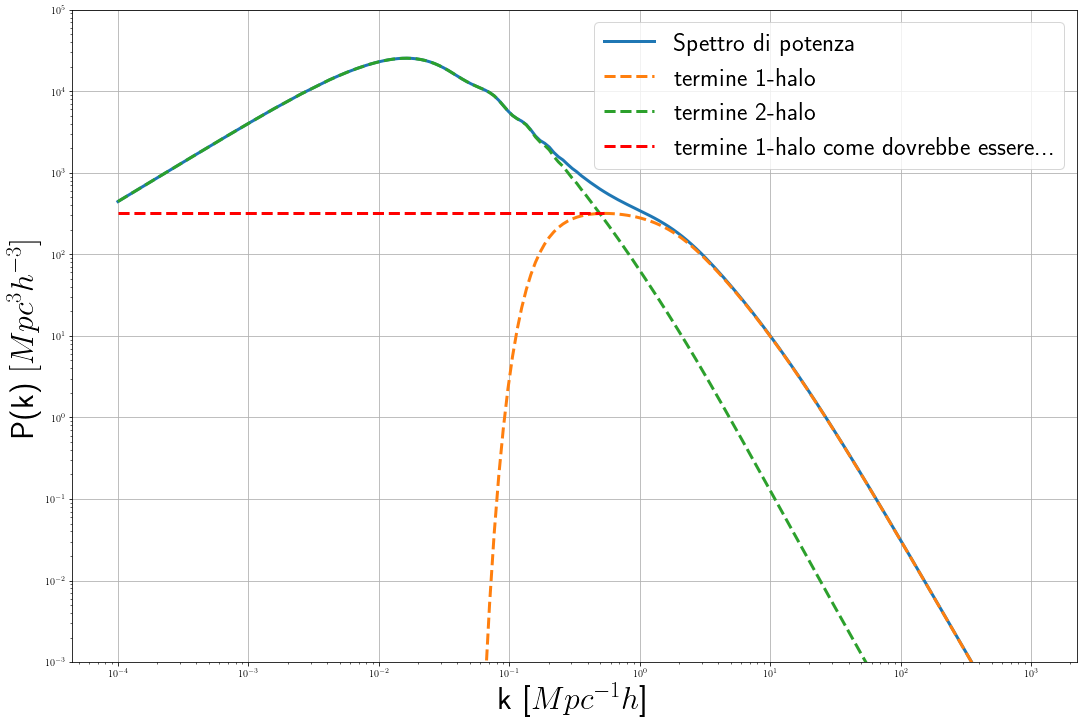

In [13]:
# IL TERMINE 1 HALO NON FUNZIONA ESATTAMENTE, È UN PROBLEMA NUMERICO (SIGH, BENVENUTI NELLA QUOTIDIANITÀ DEL FISICO)!!!
plt.figure(figsize=(18,12))
plt.loglog(modi_k, hm_ref.power_auto_matter_fnc(modi_k), label='Spettro di potenza',lw=3)
plt.plot(modi_k, hm_ref.power_1h_auto_matter_fnc(modi_k), ls='--', label=' termine 1-halo ',lw=3)
plt.plot(modi_k, hm_ref.power_2h_auto_matter_fnc(modi_k), ls='--', label=' termine 2-halo ',lw=3)
plt.hlines(np.max(hm_ref.power_1h_auto_matter_fnc(modi_k)),modi_k[0],modi_k[index_1h_max] ,color = 'red', ls='--', label=' termine 1-halo come dovrebbe essere...',lw=3)

plt.grid()
plt.legend(fontsize=25)
plt.xlabel("k [$Mpc^{-1} h$]",size=32)
plt.ylabel(r" P(k)$  \ [{ Mpc^3}h^{-3}]$",size=32);

plt.ylim(1e-3,1e5)


In [14]:
# Interludio: correggere le bizzarrie numeriche, al volo

In [15]:
max_val_1h = np.max(hm_ref.power_1h_auto_matter_fnc(modi_k)) # valore corrispondente

(0.0001, 10000.0)

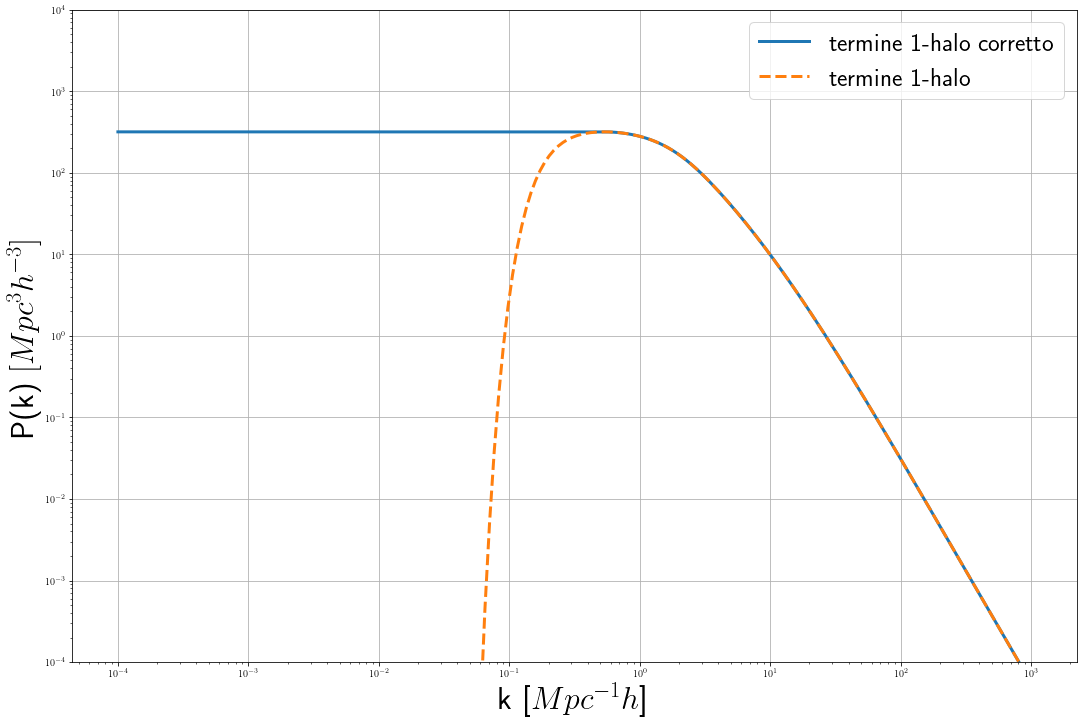

In [16]:
plt.figure(figsize=(18,12))
plt.plot(modi_k, pk_1halo_corretto(modi_k,hm_ref), ls='-', label=' termine 1-halo corretto ',lw=3)
plt.plot(modi_k, hm_ref.power_1h_auto_matter_fnc(modi_k), ls='--', label=' termine 1-halo ',lw=3)

plt.grid()
plt.legend(fontsize=25)
plt.xlabel("k [$Mpc^{-1} h$]",size=32)
plt.ylabel(r" P(k)$  \ [{ Mpc^3}h^{-3}]$",size=32);
plt.loglog()
plt.ylim(1e-4,1e4)

## 1.2 Dallo spettro alla simulazione

Le simulazioni cosmologiche complete richiedono grande potenza di calcolo e la soluzione di complessi e lunghi calcoli per determinare la traiettoria delle particelle, sia che si modellino i soli effetti gravitazionali di particelle non collisionali (simulazioni N-Body, di fatto sola materia oscura), sia che si cerchi di tenere conto di effetti più complessi dati da particelle collisionali, capaci cioè di esercitare pressione, come i barioni, con le simulazioni idrodinamiche, che, in presenza di campi magnetici, onnipresenti nell'universo, diventano le ancor più complicate simulazioni magnetoidrodinamiche. 

Tuttavia, si può accelerare il processo ricorrendo alle proprietà statistiche della struttura a grande scala! L'universo ha una densità media $\bar{\rho}$ che evolve nel tempo, rispetto alla quale le strutture e i vuoti rappresentano sovra e sotto densità, quantificate dal valore del contrasto di densità, ovvero la differenza tra la densità locale e quella media dell'universo che ci ospita. 

Notare che la densità locale è funzione della posizione (per questo è *locale*) e del redshift, mentre la densità media è la stessa in tutto l'universo e cambia solo con il redshift $\delta(\textbf{x},z) = \dfrac{\rho(\textbf{x},z) - \bar{\rho}(z) }{\bar{\rho}(z)}$.
Si tratta di un numero compreso tra - 1 (densità locale nulla) e, volendo, infinito, o arbitrariamente grande rispetto alla densità media (strutture molto molto dense concentrate). 
Ora, la cosmologia diventa non lineare quando tale contrasto diventa confrontabile con 1 o superiore, cosa che accade tipicamente:
- a piccole scale (grandi $k$)
- a basso redshift. 

Per avere una scala di riferimento, tenete presente che, ad oggi, il contrasto di densità vale 

- $10^6$ alla scala delle galassie,
- $10^3$ alla scala degli ammassi,
- $1-10$ allla scala dei superammassi.

Notate che decresce man mano che si va a strutture più grandi, cioè, "zoomando" indietro, ci si avvicina sempre di più all'omogeneità con densità pari alla densità media del background (contrasto vicino a 0) ma, nel contempo, strutture ancora molto grandi sono di fatto lontane dall'ipotesi lineare.

Tale passaggio dalla linearità alla non linearità determina un cambiamento delle proprietà statistiche della struttura a grande scala. Originariamente, il valore dell'ampiezza di tali "semi" di contrasto di densità può essere considerato un numero casuale (notare non c'è un meccanismo deterministico conosciuto!) dato dalle fluttuazioni quantistiche dello spazio tempo di poco successive al Big Bang, è distribuito come una gaussiana ("normalmente"). 
La distribuzione normale del contrasto di densità $$f(x) = \frac{1}{\sqrt{ 2 \pi \sigma(x)^2}} e^{\frac{-x^2}{2\ \sigma(x)^2}} $$ ha media 0 (perché in media la densità è la densità media, quindi il contrasto medio è zero) e varianza $\sigma^2(x)$ funzione della posizione (o, nello spazio di Fourier, della scala $k$). Lo spettro di potenza ci dà in sostanza i valori della varianza ad ogni scala k e, siccome sappiamo che il contrasto in media è nullo, è la **sola funzione** che contiene **tutte le informazioni** necessarie per descrivere l'universo! **Una singola funzione**!

Ora, quando le strutture si formano, la distribuzione delle fluttuazioni cambia: in particolare, gli effetti della gravità a piccole scale $\textit{correlano}$.Questo vuol dire che la varianza non dipende solo dalla singola scala $k$, ma anche da eventuali coppie di scale $\sigma^2(k_1,k_2)$ (in un caso discreto, la matrice di covarianza diventa non più diagonale, lo spettro di potenza, che è la sua controparte continua, cambia forma e viene descritto dall'halo model). Si noti, en passant, che a grandi scale l'inflazione dopo il Big Bang ha un effetto simile, inducendo un livello di non-gaussianità primordiale non nullo. 

Tale modificazione nelle proprietà statistiche dell'universo fa sì che la distribuzione della variabile casuale "contrasto di densità" si avvicini ad una $\textit{log}$-normale, $$f(x)=\frac{e^{-\frac{(\ln x-\mu)^2}{2\sigma^2}}}{x \sqrt{2\pi}{\sigma}}$$
cioè una distribuzione che rimane sempre compresa tra - 1 e infinito (là dove, tra l'altro, la distribuzione normale può assumere valori negativi arbitrariamente alti e non fisici, perché la varianza, cioè lo spettro di potenza, cresce al decrescere del redshift).
Inoltre, siccome le strutture si formano prima a piccola scala, diventa automaticamente più probabile trovare eccessi di contrasto di densità, valori grandi e positivi rispetto ad una distribuzione normale. Mentre le code della distribuzione normale sono simmetriche, la lognormale ha lunghe code positive, catturando questo effetto, e nel contempo il sposta il proprio picco verso valori negativ del contrasto di densità. 
Si noti che la distribuzione lognormale resta un $\textbf{modello statistico}$, la vera distribuzione di materia potrebbe essere diversa e più complicata, al limite non disporre neppure di una forma analitica chiusa, di una "formula", ma già Hubble aveva notato che questa distribuzione descrive molto bene il posizionamento spaziale delle galassie, ed è ragionevolmente un buon modello empirico. 
Nell'immagine sotto vediamo bene come una distribuzione normale può venir progressivamente distorta in una gaussiana, e come le code crescano di lunghezza al crescere della varianza, mentre per varianza piccola la distribuzione è indistinguibile da una gaussiana simmetrica (la funzione è centrata in 1 perché qui viene mostrato il rapporto tra il valore della densità e la densità media : 

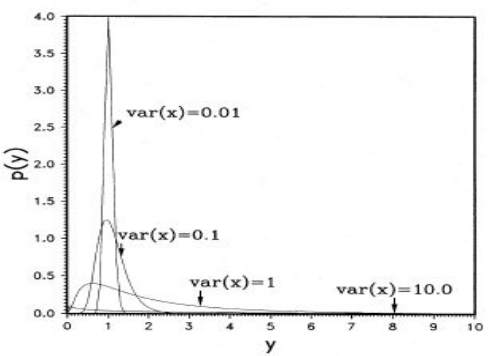

Ora, si può ribaltare il discorso: se noi abbiamo un modello *statistico* (non fisico, mi raccomando) per la distribuzione della materia nell'universo, possiamo evitare di fare tutti i calcoli retrostanti una vera simulazione cosmologica e popolare un cubo di dati, che rappresenta una regione dell'universo, con dei valori di densità estratti da una distribuzione lognormale per la quale abbiamo specificato, ad un dato redshift, uno spettro di potenza.
E, siccome si tratta di estrarre dei valori da una densità di probabilità, non risolvere equazioni, il processo è infinitamente più rapido, nell'ordine di qualche minuto: si può facilmente eseguire una simulazione su di un computer portatile. 

D'altra parte, come sempre succede in fisica, quando le scale diventano molto non lineari, il meccanismo non funziona più: il contrasto di densità ha una frequenza di valori molto elevati e positivi maggiore di quanto predetto da una lognormale. Indicativamente, riusciamo a riprodurre la non-linearità in modo indistinguibile dalle simulazioni e dalla teoria fino a scale k ∼ $3 Mpc^{-1}$, cioè fino a circa la scala degli ammassi di galassie, con una lusinghiera precisione dell'1\%.


### Caratteristiche di una simulazione

In [17]:
boxlength = 1000
N = 256
print('Massimo k campionato: ',np.pi * N / boxlength, 'h / Mpc')
print('Minima scala campionata:',2*np.pi/boxlength, 'h / Mpc')
# Ovvero, scale più piccole delle scale tipiche degli ammassi di galassie, "vediamo" la non linearità 
# dello spettro di potenza

Massimo k campionato:  0.8042477193189871 h / Mpc
Minima scala campionata: 0.006283185307179587 h / Mpc


In generale, una simulazione appare come una "scatola", una regione di cielo cubica o a forma di parallelepipedo.

Gli ingredienti necessari sono:

- **Le dimensioni**, che determinano quanta parte di universo vogliamo riprodurre: più la scatola è grande, più le sue proprietà si avvicineranno alle proprietà medie, ma riusciremo a vedere anche meglio le strutture della ragnatela cosmica. Viceversa, scatole piccole si concentrano su scale non lineari. Non si può andare a scale arbitrariamente alte per via dei limiti menzionati sopra delle distribuzioni lognormali nel riprodurre la non-linearità.
- **La risoluzione**, determinata dalla griglia con la quale il lato della simulazione viene diviso in N parti, che determina la dimensione di ogni cella (voxel); questa dimensione minima determina a sua volta determina la scala più piccola campionata. 

Inoltre, si può avere interesse a calibrare le dimensioni della simulazione in modo tale da campionare adeguatamente una data regione dello spettro, ad esempio le oscillazioni acustiche barioniche (BAO, con una dimensione tipica di 150 Mpc), ovvero riuscire a raccogliere sufficienti valori del campo di densità a quella scala affinché sia statisticamente robusto e affidabile (in altre parole: possiamo dire che tutte le mele sono rosse solo perché ne abbiamo vista una rossa? No, abbiamo bisogno di un numero ragionevole di campioni per trarre conclusioni sicure). 

Inoltre, vogliamo "vedere nel dettaglio" le scale di interesse, *risolverle* con precisione in un'immagine rispetto alle altre scale, esattamente come la qualità di una macchina fotografica è determinata (anche) dalla sua risoluzione. 

In generale, il più piccolo modo che può venir misurato è pari a $k_{\rm{min}} = 2\pi/L$  dove $L$ è la lunghezza del lato della scatola, mentre il modo più grande, pari alla frequenza di Nyquist del sistema, è pari a $k_{\rm{max}} = N_{\rm{griglia}}\pi/L$. Il modo $k_\rm{min}$ dà anche un'indicazione sulla risoluzione (dimensione del bin di campionamento), che devono essere un paio di volte almeno minore della scala che si vuole campionare con precisione (principio di Nyquist). 

In altre parole:
- Più è grande la scatola, più è efficace il campionamento (riduco la varianza, ovvero la "rumorosità" del campione, la deviazione dal valor medio atteso e calcolato dalla teoria). 
- Ma per accedere a scale più piccole, devo aumentare la finezza della griglia. Tuttavia, questo aumenta:
    - Il tempo di esecuzione della simulazione
    - Il peso (fino a qualche Gb) della simulazione stessa, che potrebbe saturare la memoria del computer o comunque dare dei problemi.
    
Come spesso accade in fisica, ciò che si vuole fare è un $\textbf{compromesso}$ di tante variabili, e non c'è una risposta univoca, bensì $\textbf{dipende}$ da ciò che uno vuole fare!
 
Temi di discussione: lognormali, linearità, non linearità. Come si campiona?

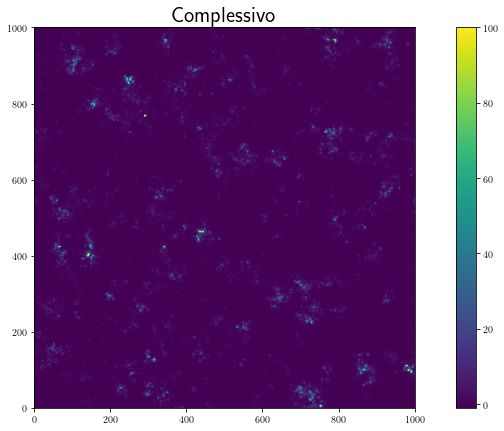

In [18]:
# Sezione bidimensionale di una simulazione a dato redshift

plt.figure(figsize=(15,7))
plt.title('Complessivo',size=22)

plt.imshow(lnpb_ref_tot.delta_x(),extent=(0,boxlength,0,boxlength),cmap='viridis',alpha=1.,vmax=100)
plt.colorbar()
plt.show()

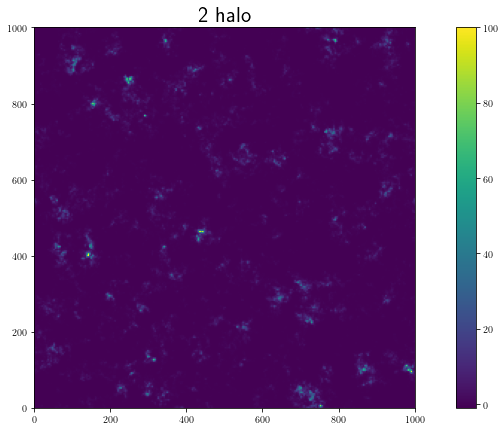

In [19]:
# Sezione bidimensionale di una simulazione a dato redshift

plt.figure(figsize=(15,7))
plt.title('2 halo',size=22)

plt.imshow(lnpb_ref_2h.delta_x(),extent=(0,boxlength,0,boxlength),cmap='viridis',alpha=1.,vmax=100)
plt.colorbar()
plt.show()

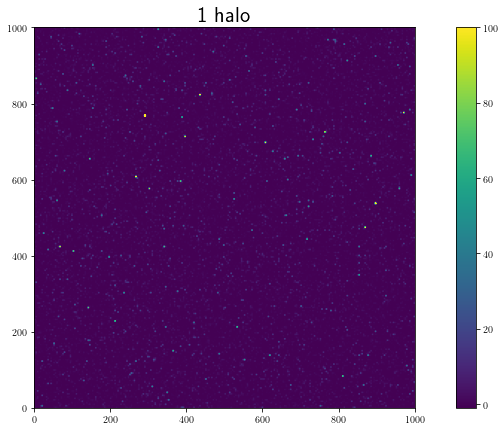

In [20]:
# Sezione bidimensionale di una simulazione a dato redshift

plt.figure(figsize=(15,7))
plt.title('1 halo',size=22)

plt.imshow(lnpb_ref_1h.delta_x(),extent=(0,boxlength,0,boxlength),cmap='viridis',alpha=1.,vmax=100)
plt.colorbar()
plt.show()

In [21]:
pb = pbox.LogNormalPowerBox(N=N, dim=3, pk = lambda k: hm_ref.power_auto_matter_fnc(k), boxlength= boxlength, seed=1234,ensure_physical=True)

In [22]:
deltax = pb.delta_x() # altra cosa importante: ci vuole del tempo...

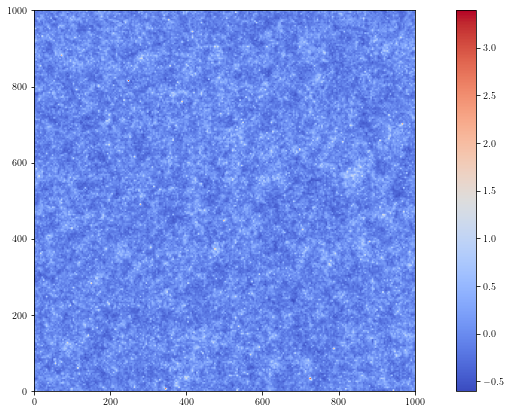

In [23]:
plt.figure(figsize=(15,7))

plt.imshow(np.mean(deltax[:,:,:],axis=0),extent=(0,boxlength,0,boxlength),cmap='coolwarm',) # capire che cosa si intende
plt.colorbar()

plt.show()

[]

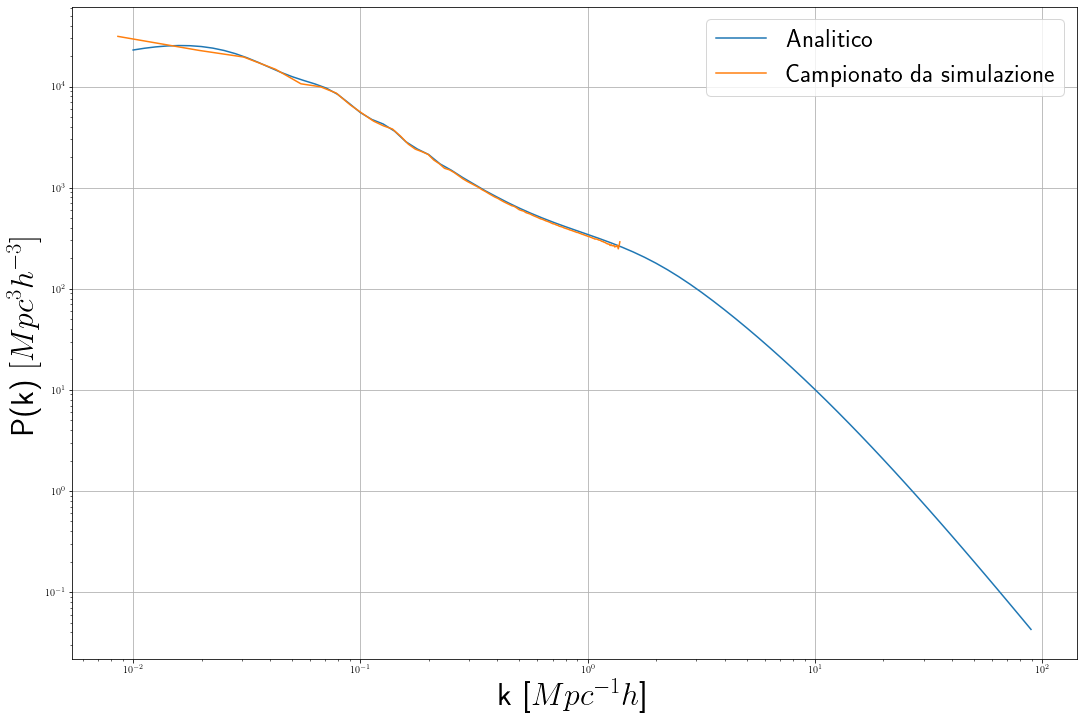

In [24]:
# Estraggo lo spettro di potenza dalla simulazione, 

p_k, kbins = pbox.get_power(deltax,pb.boxlength,)#,bins = 80)


plt.figure(figsize=(18,12))
plt.loglog(hm_ref.k_hm, hm_ref.power_auto_matter_fnc(hm_ref.k_hm), label='Analitico')
plt.plot(kbins,p_k,label="Campionato da simulazione")

plt.grid()
plt.legend(fontsize=25)
plt.xlabel("k [$Mpc^{-1} h$]",size=32)
plt.ylabel(r" P(k)$  \ [{ Mpc^3}h^{-3}]$",size=32);
plt.loglog()
#plt.ylim(1e-4,1e4)

#plt.xlim(2*1e-2,1)

## Che cosa accade cambiando la cosmologia di riferimento?

In [25]:
#hm_alt.cosmo

In [26]:
ref_Om_0 = hmf.cosmo.Planck15.Om0
ref_Ob_0 = hmf.cosmo.Planck15.Ob0
ref_H_0 = hmf.cosmo.Planck15.H0

# Generiamo cosmologia di riferimento

hm_alt = DMHaloModel(cosmo_params = {'Ob0':0.22})
       # 'Om0': 0.3,
       # 'H0': 46.0,})

redshift = 0.

hm_alt.z = redshift
#hm_alt.cosmo_params['OmO'] = ref_Om_0#/2
#hm_alt.cosmo_params['ObO'] = ref_Ob_0#*15
#hm_alt.cosmo_params['H0'] = ref_H_0#*15
hm_alt.sigma_8 = 1.#4

hm_alt.tracer_profile_model = "NFW" # Primo ingrediente: profilo di densità dell'alone di materia oscura
# Navarro - Frenk - White, lo standard più comune

hm_alt.bias_model = 'ST99'  # Secondo ingrediente, il "bias dell'alone"

hm_alt.hmf_model = 'ST' # Terzo ingrediente: la funzione di massa, quanti (in numero) aloni abbiamo nell'universo per ogni valore di massa dell'alone?

modi_k = np.logspace(-4,3,200) # Generiamo più modi di quelli che halomod normalmente associa agli spettri (pur calcolando il valore dello spettro corrispondente), servirà dopo

# Genero lo spettro di potenza, termini 1halo, 2halo e complessivo

index_1h_max = np.where(hm_alt.power_1h_auto_matter_fnc(modi_k) == np.max(hm_alt.power_1h_auto_matter_fnc(modi_k)))[0] 


max_val_1h = np.max(hm_alt.power_1h_auto_matter_fnc(modi_k)) # valore corrispondente

# Ridefinisco la funzione del 1halo a tratti, in modo che a grandi scale (piccoi k) restituisca un plateau

def pk_1halo_corretto(k,pk):
    
    return np.piecewise(k, [k < modi_k[index_1h_max],k >= modi_k[index_1h_max] ], [lambda x: max_val_1h ,lambda x :pk.power_1h_auto_matter_fnc(x)])



In [27]:
# Generazione della simulazione di riferimento, LCDM

boxlength = 1000
N = 256
#print('Massimo k campionato: ',np.pi * N / boxlength, 'h / Mpc')
#print('Minima scala campionata:', boxlength/N, 'h / Mpc')
# Ovvero, scale più piccole delle scale tipiche degli ammassi di galassie, "vediamo" la non linearità 
# dello spettro di potenza

# Sezione bidimensionale di una simulazione a dato redshift

lnpb_alt_tot = pbox.LogNormalPowerBox(
    N=N,                     # Number of grid-points in the box
    dim=2,                     # 2D box
    pk = lambda k: hm_alt.power_auto_matter_fnc(k), # The power-spectrum
    boxlength = boxlength    ,       # Size of the box (sets the units of k in pk)
    seed = 1010,ensure_physical=True
    # Use the same seed as our powerbox
)

lnpb_alt_2h = pbox.LogNormalPowerBox(
    N=N,                     # Number of grid-points in the box
    dim=2,                     # 2D box
    pk = lambda k: hm_alt.power_2h_auto_matter_fnc(k), # The power-spectrum
    boxlength = boxlength    ,       # Size of the box (sets the units of k in pk)
    seed = 1010,ensure_physical=True
    # Use the same seed as our powerbox
)

lnpb_alt_1h = pbox.LogNormalPowerBox(
    N=N,                     # Number of grid-points in the box
    dim=2,                     # 2D box
    pk = lambda k: pk_1halo_corretto(k,hm_alt), # The power-spectrum
    boxlength = boxlength    ,       # Size of the box (sets the units of k in pk)
    seed = 1010,ensure_physical=True
    # Use the same seed as our powerbox
)

/home/andrea/anaconda3/envs/progetto_1/lib/python3.11/site-packages/halomod/tools.py:653: UserWarning: You are using an un-normalized mass function and bias function pair.Bias ST99 has the following paired HMF model: (<class 'hmf.mass_function.fitting_functions.SMT'>,). Matter correlations are not well-defined.
  warnings.warn(
/home/andrea/anaconda3/envs/progetto_1/lib/python3.11/site-packages/powerbox/powerbox.py:386: RuntimeWarning: invalid value encountered in log
  return np.log(1 + self.correlation_array())


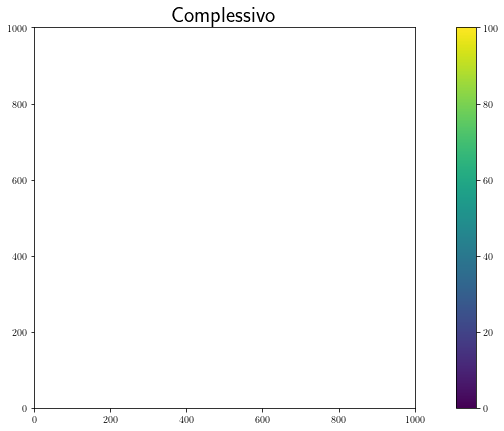

In [28]:
# Sezione bidimensionale di una simulazione a dato redshift

plt.figure(figsize=(15,7))
plt.title('Complessivo',size=22)

plt.imshow(lnpb_alt_tot.delta_x(),extent=(0,boxlength,0,boxlength),cmap='viridis',alpha=1.,vmax=100)
plt.colorbar()
plt.show()

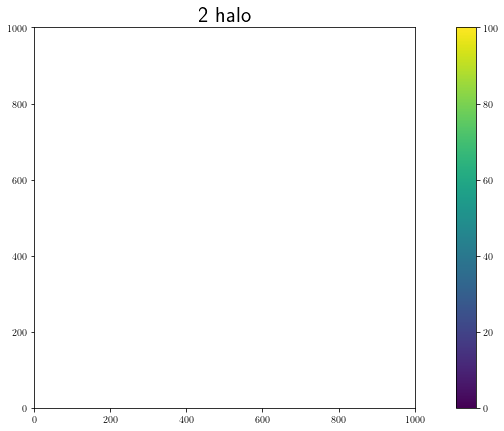

In [29]:
# Sezione bidimensionale di una simulazione a dato redshift

plt.figure(figsize=(15,7))
plt.title('2 halo',size=22)

plt.imshow(lnpb_alt_2h.delta_x(),extent=(0,boxlength,0,boxlength),cmap='viridis',alpha=1.,vmax=100)
plt.colorbar()
plt.show()

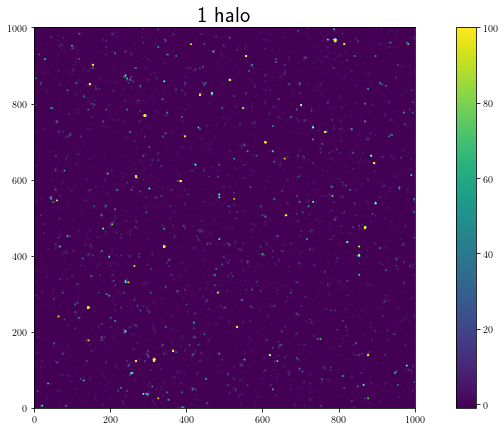

In [30]:
# Sezione bidimensionale di una simulazione a dato redshift

plt.figure(figsize=(15,7))
plt.title('1 halo',size=22)

plt.imshow(lnpb_alt_1h.delta_x(),extent=(0,boxlength,0,boxlength),cmap='viridis',alpha=1.,vmax=100)
plt.colorbar()
plt.show()

In [31]:
pb_confronto = pbox.LogNormalPowerBox(N=N, dim=3, pk = lambda k: hm_alt.power_auto_matter_fnc(k), boxlength= boxlength, seed=1234,ensure_physical=True)

In [32]:
deltax_alt = pb_confronto.delta_x() # altra cosa importante: ci vuole del tempo...

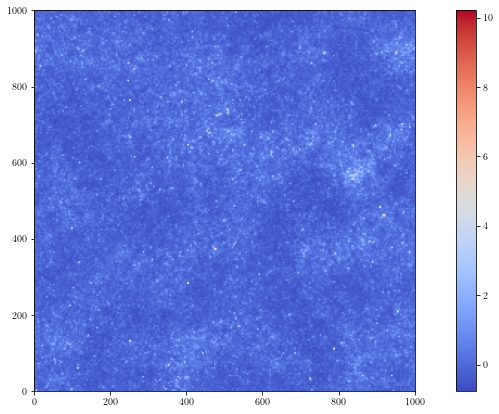

In [33]:
plt.figure(figsize=(15,7))

plt.imshow(np.mean(deltax_alt[:,:,:],axis=0),extent=(0,boxlength,0,boxlength),cmap='coolwarm') # capire che cosa si intende
plt.colorbar()
plt.show()

[]

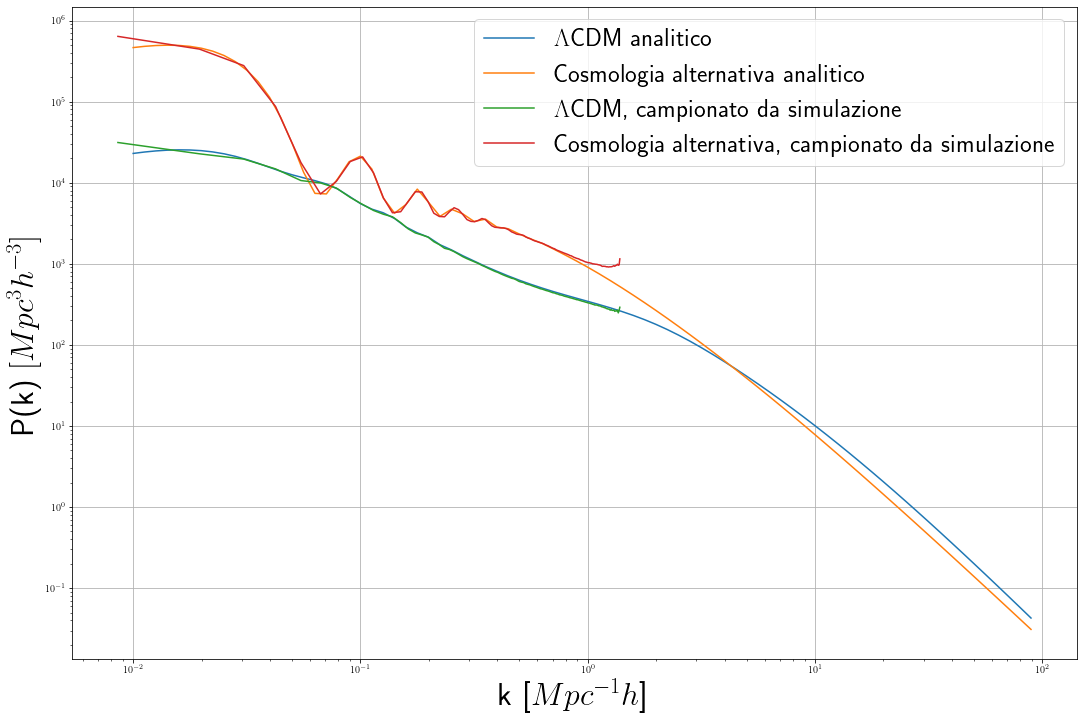

In [34]:
# Estraggo lo spettro di potenza dalla simulazione, 

p_k_alt, kbins = pbox.get_power(deltax_alt,pb.boxlength,)#,bins = 80)


plt.figure(figsize=(18,12))
plt.loglog(hm_ref.k_hm, hm_ref.power_auto_matter_fnc(hm_ref.k_hm), label='$\Lambda$CDM analitico')
plt.loglog(hm_alt.k_hm, hm_alt.power_auto_matter_fnc(hm_ref.k_hm), label='Cosmologia alternativa analitico')

plt.plot(kbins,p_k,label="$\Lambda$CDM, campionato da simulazione")
plt.plot(kbins,p_k_alt,label="Cosmologia alternativa, campionato da simulazione")

plt.grid()
plt.legend(fontsize=25)
plt.xlabel("k [$Mpc^{-1} h$]",size=32)
plt.ylabel(r" P(k)$  \ [{ Mpc^3}h^{-3}]$",size=32);
plt.loglog()
#plt.ylim(1e-4,1e4)

#plt.xlim(2*1e-2,1)

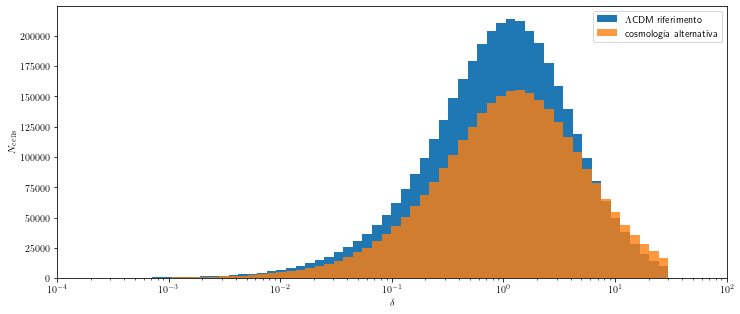

In [35]:
# Vediamo se effettivamente abbiamo una distribuzione lognormale
plt.figure(figsize=(12,5))
bins = np.logspace(-7, np.log10(30.), 100)
_ = plt.hist((pb.delta_x()).flatten(), bins=bins,label='$\Lambda$CDM riferimento')
_ = plt.hist((pb_confronto.delta_x()).flatten(), bins=bins,label='cosmologia alternativa',alpha=0.8)

# format the axes
#plt.xscale('log')
plt.xlabel(r"$\delta$")
plt.ylabel(r"$N_\mathrm{cells}$")
plt.xlim(1e-4,100 )
plt.semilogx()
plt.legend()

Costruiamo ora una simulazione 3D per estrarre lo spettro di potenza

Temi di discussione: profondità in redshift, che senso ha uno spettro 3D a z fissato?

In [36]:
pb = pbox.LogNormalPowerBox(N=N, dim=3, pk = lambda k: hm_ref.power_auto_matter_fnc(k), boxlength= boxlength, seed=1234)

In [37]:
deltax = pb.delta_x() # altra cosa importante: ci vuole del tempo...

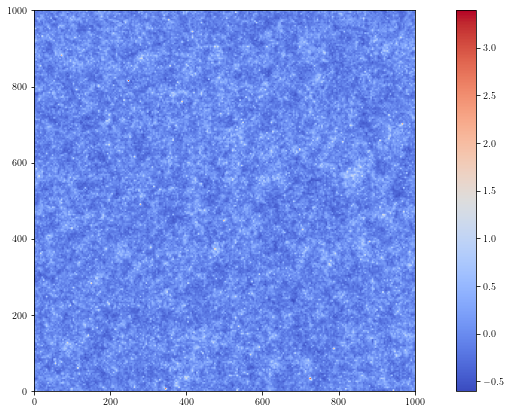

In [38]:
plt.figure(figsize=(15,7))

plt.imshow(np.mean(deltax[:,:,:],axis=0),extent=(0,boxlength,0,boxlength),cmap='coolwarm') # capire che cosa si intende
plt.colorbar()
plt.show()

In [39]:
# Estraggo lo spettro di potenza dalla simulazione, 

p_k, kbins = pbox.get_power(deltax,pb.boxlength,)#,bins = 80)


[]

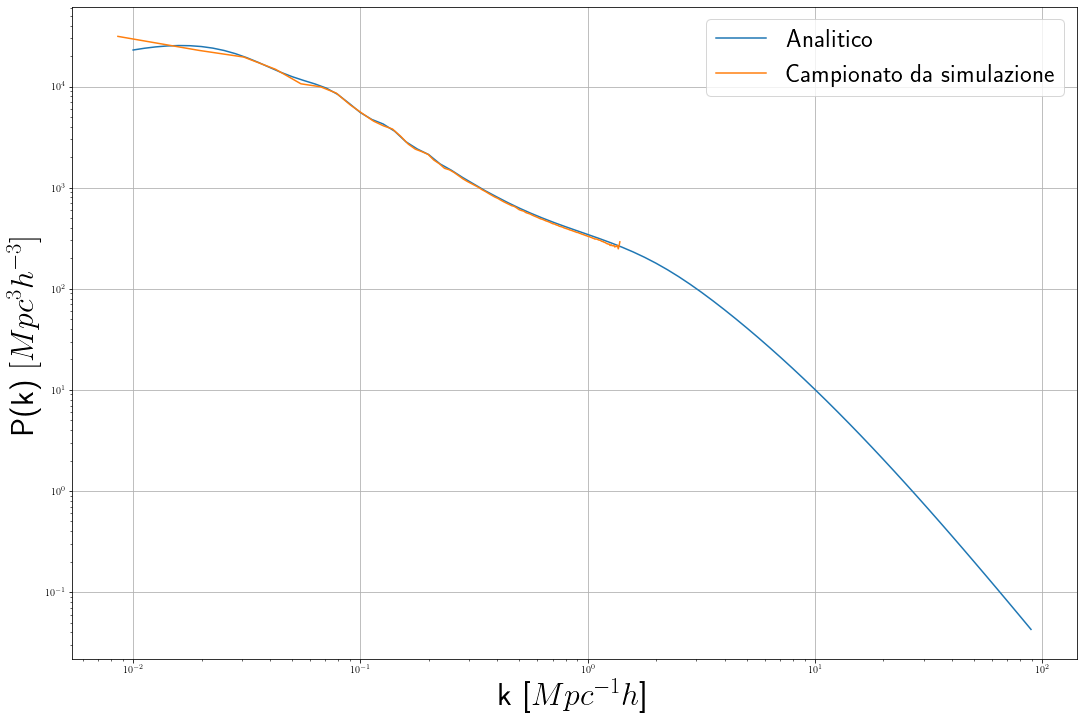

In [40]:
plt.figure(figsize=(18,12))
plt.loglog(hm_ref.k_hm, hm_ref.power_auto_matter_fnc(hm_ref.k_hm), label='Analitico')
plt.plot(kbins,p_k,label="Campionato da simulazione")

plt.grid()
plt.legend(fontsize=25)
plt.xlabel("k [$Mpc^{-1} h$]",size=32)
plt.ylabel(r" P(k)$  \ [{ Mpc^3}h^{-3}]$",size=32);
plt.loglog()
#plt.ylim(1e-4,1e4)

#plt.xlim(2*1e-2,1)

# 2.Perché lo spettro di potenza ha la forma che vediamo?

Sotto vediamo due grafici che rappresentano lo spettro di potenza delle strutture cosmiche: ha una bellezza quasi artistica, lo splendore della quantità di informazioni, la possibilità che ci dà di descrivere e riassumere la nostra (ancora incompleta, forse in parte erronea) comprensione dell'universo, mescolata all'eleganza della teoria retrostante, la relatività generale, racchiusa tuttavia in una grande semplicità.
La versione a sinistra è molto significativa perché ci mostra come sia stato possibile effettuare varie misure, comprendo tantissime scale di interesse cosmologico ed astrofisico, ricorrendo a diverse campagne osservative e osservabili fisiche, dalla radiazione cosmica di fondo -- l'unica che finora ci ha consentito di misurare le scale più grandi, prima dell'inversione di pendenza -- alle misure a piccole scale ottenute con la foresta Lyman-$\alpha$.

A destra abbiamo una sua rappresentazione artistica, che ci mostra invece le sue proprietà salienti (la sua "topografia", caratterizzata dal punto di inversione e dal segnale ondulatorio delle oscillazioni acustiche barioniche - si noti che le BAO **non sono oscillazioni perché il segnale che vediamo nello spazio di Fourier è ondulato!**, ne parleremo meglio più avanti) e lo scompone negli andamenti diversi funzione della scala, che indagheremo in questa sezione. 

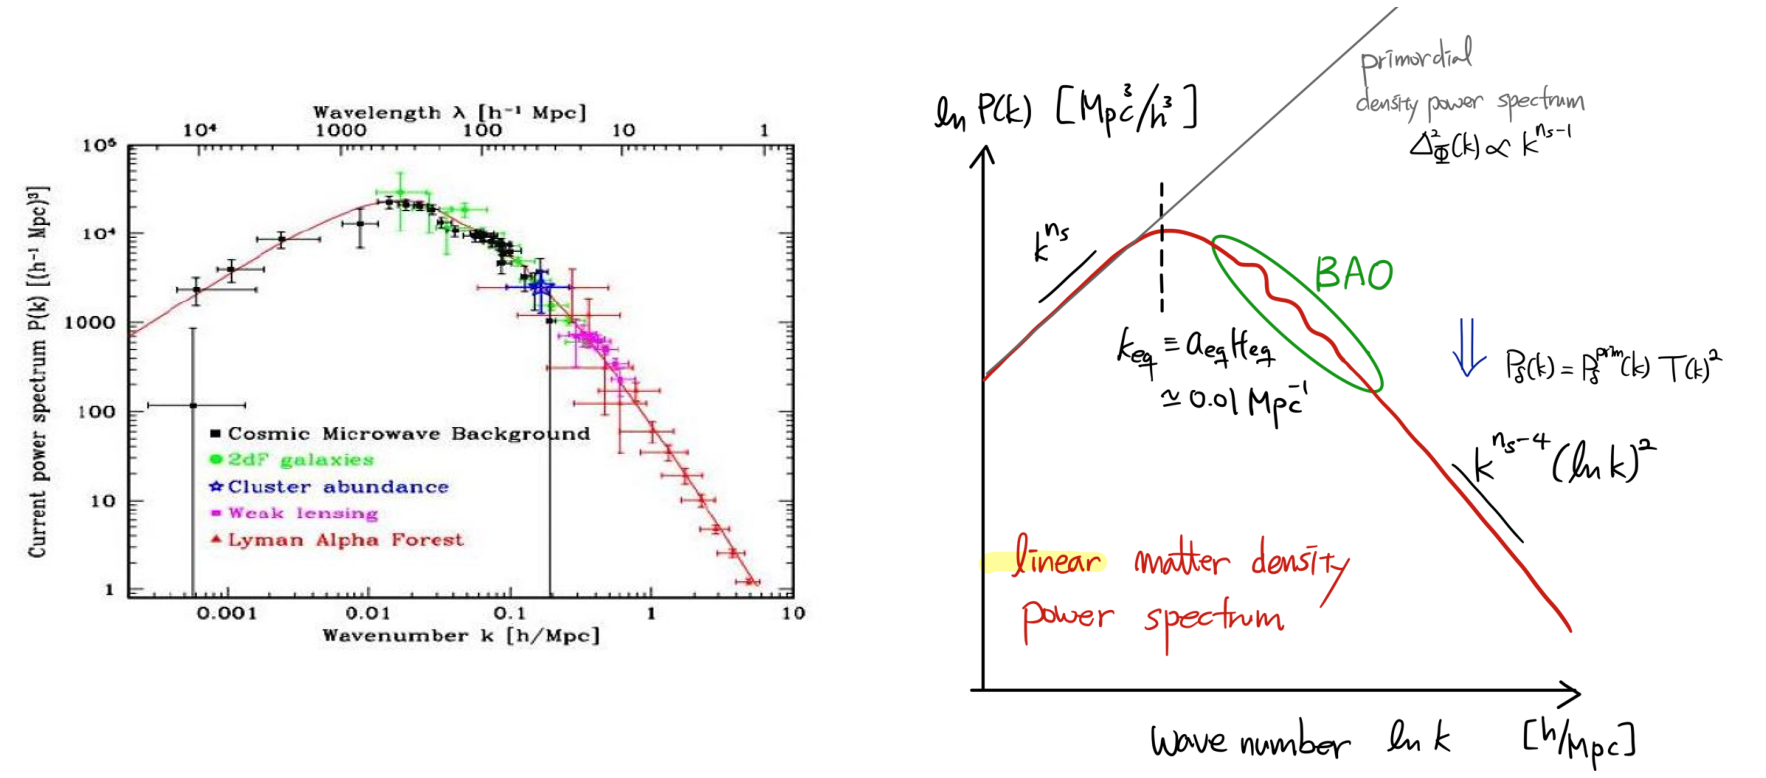

In [41]:
import matplotlib.image as mpimg
# read images
img_A = mpimg.imread('aggiungimi.jpg')
img_B = mpimg.imread('spettro_artistico.png')

# display images
fig, ax = plt.subplots(1,2,figsize=(25,12))
fig.tight_layout()
ax[0].axis('off');
ax[1].axis('off');
ax[0].imshow(img_A,)
ax[1].imshow(img_B)

Ma perché lo spettro di potenza ha la forma che vediamo? In generale, il suo andamento si può riassumere nella formula qui sotto: 

$$ P(k,z) = D(z) \ T (k) \ P_{\rm{primordiale}} (k)$$

Si tratta di una formulazione molto semplice e con la sua eleganza, in quanto ci sta dicendo che, fissato uno spettro primordiale, funzione solo del modo $k$, è possibile spostarci avanti e indietro nel tempo tramite la funzione di crescita $D(z)$, mentre la forma dello spettro *ad ogni modo k* viene modificata dalla funzione di crescita T(k). Si noti che le modifiche spaziali (fondamentalmente, cambio di pendenza dall'andamento rettilineo originario che ancora caratterizza le scale più grandi, ovvero i modi più piccoli) sono indipendenti dalle modifiche temporali, che fissano l'ampiezza dello spettro ad ogni redshift. Questa proprietà è un'altra manifestazione del concetto di linearità ma, sia ben chiaro, è vera appunto **solo in regime lineare**, dove è possibile disaccoppiare le interazioni tra le varie scale.

Ma perché lo spettro ha la forma che vediamo? Per capirlo, ricorreremo ad un altro strumento fondamentale del cosmologo, il Boltzmann solver $\texttt{CAMB}$. Un Boltzmann solver è un codice che combina l'evoluzione delle perturbazioni nello spazio (di Fourier) e nel tempo, dettata dalla relatività generale, con l'equazione di Boltzmann.
Questa equazione ha come incognita una funzione di di distribuzione, solitamente denotata con $f(\textbf{x},z)$ o $n(\textbf{x},z)$,  che può essere interpretata come una densità numerica (particelle per unità di volume). Per ogni specie di materia che popola l'universo, vogliamo la sua distribuzione di densità ad ogni dato istante e posizione, perché da questa è possibile ricavare la densità e la pressione del fluido, accoppiate tramite un'*equazione di stato* che consente poi di risolvere le equazioni per le perturbazioni di densità. 

Sembra facile? Non lo è per nulla, perché la funzione di distribuzione dipende da energia e temperatura del fluido, da interazioni che inducono annichilazioni e decadimenti, dunque creano e distruggono particelle, specialmente nell'universo immediatamente successivo al Big Bang, a loro voltaf funzioni dell'espansione dell'universo (effetti di background) e dalle interazioni nelle strutture (effetti perturbativi). Il Boltzmann solver risolve quindi in modo accoppiato, ad ogni redshift, perturbazioni e equazione di Boltzmann, consentendoci di stabilire lo stato dinamico e termodinamico dell'universo ad ogni istante, con una precisione che dipende da alcune condizioni, fondamentalmente collegate, come sempre, alla distinzione tra regimi lineari e non lineari. 

Per quanto complicata, l'evoluzione dei fluidi cosmologici si può però comprendere in modo relativamente semplice introducendo il concetto di **disaccoppiamento** (decoupling); ovvero, le varie specie (barioni, fotoni, materia oscura, neutrini...) interagiscono tra di loro fino a quando sono sufficientemente densi e dunque le particelle hanno un'elevata probabilità di scontrarsi, scambiandosi energia e quantità di moto. 
La probabilità di scontro dipende dal tipo di particella, fotoni e barioni sono molto interagenti, la materia oscura o i neutrini molto poco; pertanto, quanto più l'universo si espande, tanto più aumenterà il loro **cammino libero medio**, la distanza media che possono percorrere. 

Ad un certo redshift, una data specie cessa di interagire (se non per effetto della gravità) e si *disaccoppia*; da quel momento, la sua temperatura scalerà soltanto con il redshift, $T(z) = \frac{T_\rm{disacc}}{1+z}$, perché non ci saranno più interazioni che possono modificarla, a parte l'espansione dell'universo che ne "diluisce" la temperatura. Al momento, tutte le specie cosmiche originarie sono di fatto disaccoppiate, tranne barioni e materia oscura, che, assieme, costituiscono la ragnatela cosmica grazie agli effetti della gravità.

Il fenomeno più importante nella storia primordiale del cosmo, a redshift circa 1100, ovvero circa 300 mila anni dopo il Big Bang, è il disaccoppiamento tra barioni e fotoni, che determina la formazione della radiazione cosmica di fondo (fotoni primordiali disaccoppiati) e fissa nello spettro di potenza le oscillazioni acustiche barioniche. Altri effetti di interazione tra materia oscura, barioni e "free streaming" dei fotoni, cioè il loro "sfuggire" dai potenziali gravitazionali, progressivamente "spianandoli", determina il cosiddetto "processamento" dello spettro di potenza descritto dalla funzione di trasferimento $T(k)$. 

Esploreremo alcuni di questi effetti nelle prossime celle, partendo dal concetto di "entrata nell'orizzonte" delle varie scale spaziali.

## Ingresso delle perturbazioni nell'orizzonte

Le varie scale spaziali hanno una dimensione che può essere più grande o più piccola della scala dell'orizzonte di Hubble -- qualitativamente, la scala più grande che, a ogni dato redshift, i fotoni possono raggiungere, ora attorno ai 4 Gigaparsec--  portando così informazione e dunque connessione causale, in particolare, interazione gravitazionale.

Le scale più grandi dell'orizzonte sono "congelate", cioè i potenziali gravitazionali non variano nel tempo, e le perturbazioni non possono collassare, non possono, cioè, determinare la formazione di strutture. 
Con il passare del tempo, sempre più scale diventano più piccole dell'orizzonte: entrano cioè in connessione causale, e possono cominciare ad interagire. Questo determina progressivamente la formazione delle strutture, prima le scale piccole poi le scale più grandi (si parla di teoria gerarchica, o clustering gerarchico, analogo all'evoluzione della funzione di massa al decrescere del redshift), purché queste siano più grandi della scala di Jeans, una scala minima al di sotto della quale (ovvero, per strutture più piccole di $L_{\rm{Jeans}}$) una struttura non può formarsi perché la pressione dei barioni si oppone con successo al collasso, disperdendo la perturbazione.  

Un evento fondamentale nella storia dell'universo è il passaggio da un universo primordiale dominato dalla radiazione (quando, cioè, la densità dei fotoni è maggiore della densità della materia barionica e oscura) a quella dominata dalla materia (quando la densità dei fotoni diventa più piccola della densità di materia barionica ed oscura). Questo determina un fondamentale cambiamento nella crescita delle perturbazioni, che diventa più lento, determinando la formazione del punto di inversione dello spettro di potenza stesso. (Si noti che, da qualche miliardo di anni,siamo entrati nella fase in cui è l'energia oscura a dominare; l'orizzonte cioè progressivamente si *ridurrà*, determinando nuovamente un'uscita delle scale dall'orizzonte cosmologico.) 

Vedremo l'evoluzione di questi effetti, scala per scala e fluido per fluido, nelle prossime celle. 

In [42]:
# Prepariamo CAMB

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, platform, os
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import camb
from camb import model, initialpower

# Latex: per impostare la grafica "come se fosse un vero articolo scientifico"
font = {'size'   : 105, 'family':'STIXGeneral'}
#axislabelfontsize='larger'
plt.rc('text', usetex=False,)

#plt.rc('font', **font)
#plt.rcParams['text.usetex'] = False
np.set_printoptions(precision=3,linewidth=200,suppress=False)

In [43]:
# Inizializziamo la calcolatrice, come abbiamo già visto sopra
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122) # fissiamo i parametri fondamentali della cosmologia: parametro
# di Hubble, densità dei barioni, densità della materia oscura
pars.InitPower.set_params(ns=0.965) # indice dello spettro primordiale
pars.set_matter_power(redshifts=[0., 0.8], kmax=2.0) # fissiamo la scala e i redshift ai quali calcolare gli spettri
 
# Spettri lineari
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)
kh, z, pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 200)
s8 = np.array(results.get_sigma8())

# Spettri non lineari: calcolati a partire da dei modelli estratti dalle simulazioni, chiamati "Halofit", cioè
# fit degli aloni di materia oscura individuati nelle simulazioni
pars.NonLinear = model.NonLinear_both
results.calc_power_spectra(pars)
kh_nonlin, z_nonlin, pk_nonlin = results.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 200)


Note: redshifts have been re-sorted (earliest first)


In [44]:
data = camb.get_background(pars)

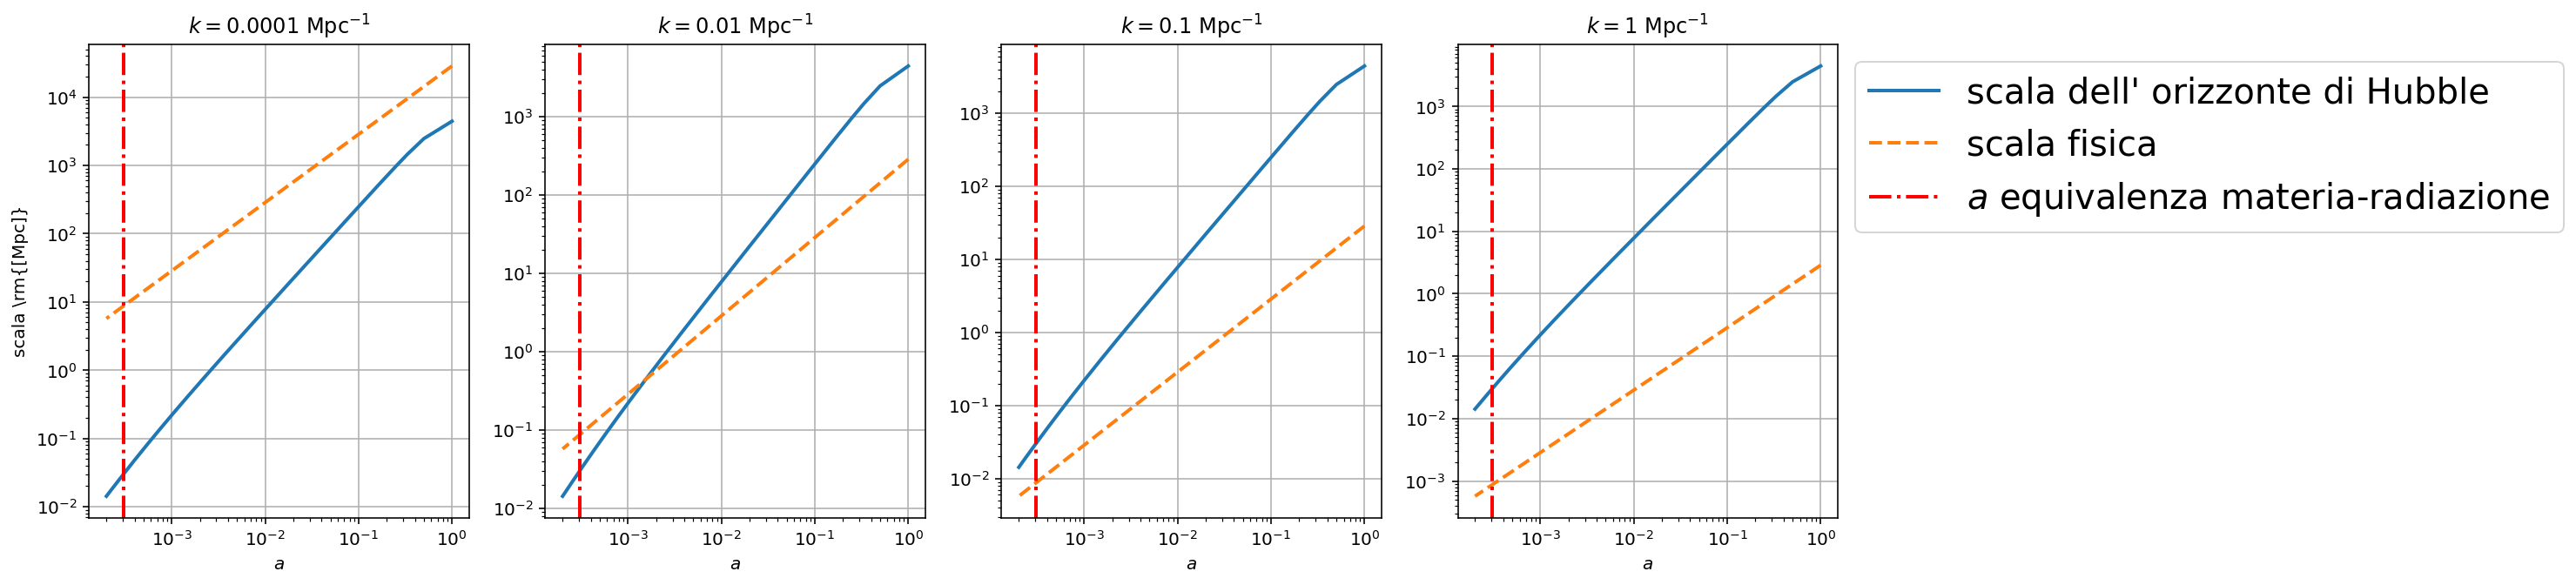

In [89]:
# Calcoliamo effettivamente le varie scale all'evolvere del redshift rispetto all'orizzonte di Hubble: a=1 è
# z= 0, cioè "oggi"

# Si tratta di scale proprie (moltiplicate per il fattore di scala), non scale comoventi, perché ci interessa la
# connessione causale (entrata nell'orizzonte)

z = np.linspace(0,5000,5000)

ks = [1e-4,1e-2,1e-1, 1]
ev = data.get_redshift_evolution(ks, z, ['delta_baryon','delta_cdm', 'delta_photon','H','a','k/h'])
_, axs= plt.subplots(1,len(ks), figsize=(18,5))
    
for i, ax in enumerate(axs):
    ax.plot(ev[1,:, -2],1/ev[i,:, -3]*ev[1,:, -2],lw=2,)
    ax.plot(ev[1,:, -2],2*np.pi/(ev[i,:, -1]/pars.h)*ev[1,:, -2],ls='--',lw=2,)
    ax.set_title(r'$k= %s \ \rm{Mpc^{-1}}$'%ks[i])
    ax.set_xlabel('$ a $');
    ax.axvline(1/(1+3300),0,1e4,ls='-.',color='red',lw=2,)
    ax.grid()
    ax.loglog()

axs[0].set_ylabel(r'scala \rm{[Mpc]}');
    
    
plt.legend(['scala dell\' orizzonte di Hubble','scala fisica', '$a$ equivalenza materia-radiazione'], ncols=1,bbox_to_anchor=(1,1),fontsize=20);


Al crescere di di $k$ (decrescere della scala di lunghezza fisica), le scale "entrano (ovvero, la retta arancione interseca quella blu) nell'orizzonte di Hubble" prima ( $a$ più piccolo, ovvero redshift $z$ più alto, perché $a = \frac{1}{1+z}$. Quando le scale entrano nell'orizzonte, sono in connessione causale, la gravità può "lavorare" e farle interagire. Notare il cambio di pendenza dell'orizzonte di Hubble.
In particolare, distinguiamo tra le scale che attraversano l'orizzonte prima o dopo il redshift dell'equivalenza ($z \sim 3300$), denotato dalla retta verticale rossa

/home/andrea/anaconda3/envs/progetto_1/lib/python3.11/site-packages/matplotlib/scale.py:253: RuntimeWarning: overflow encountered in power
  return np.power(self.base, a)


[]

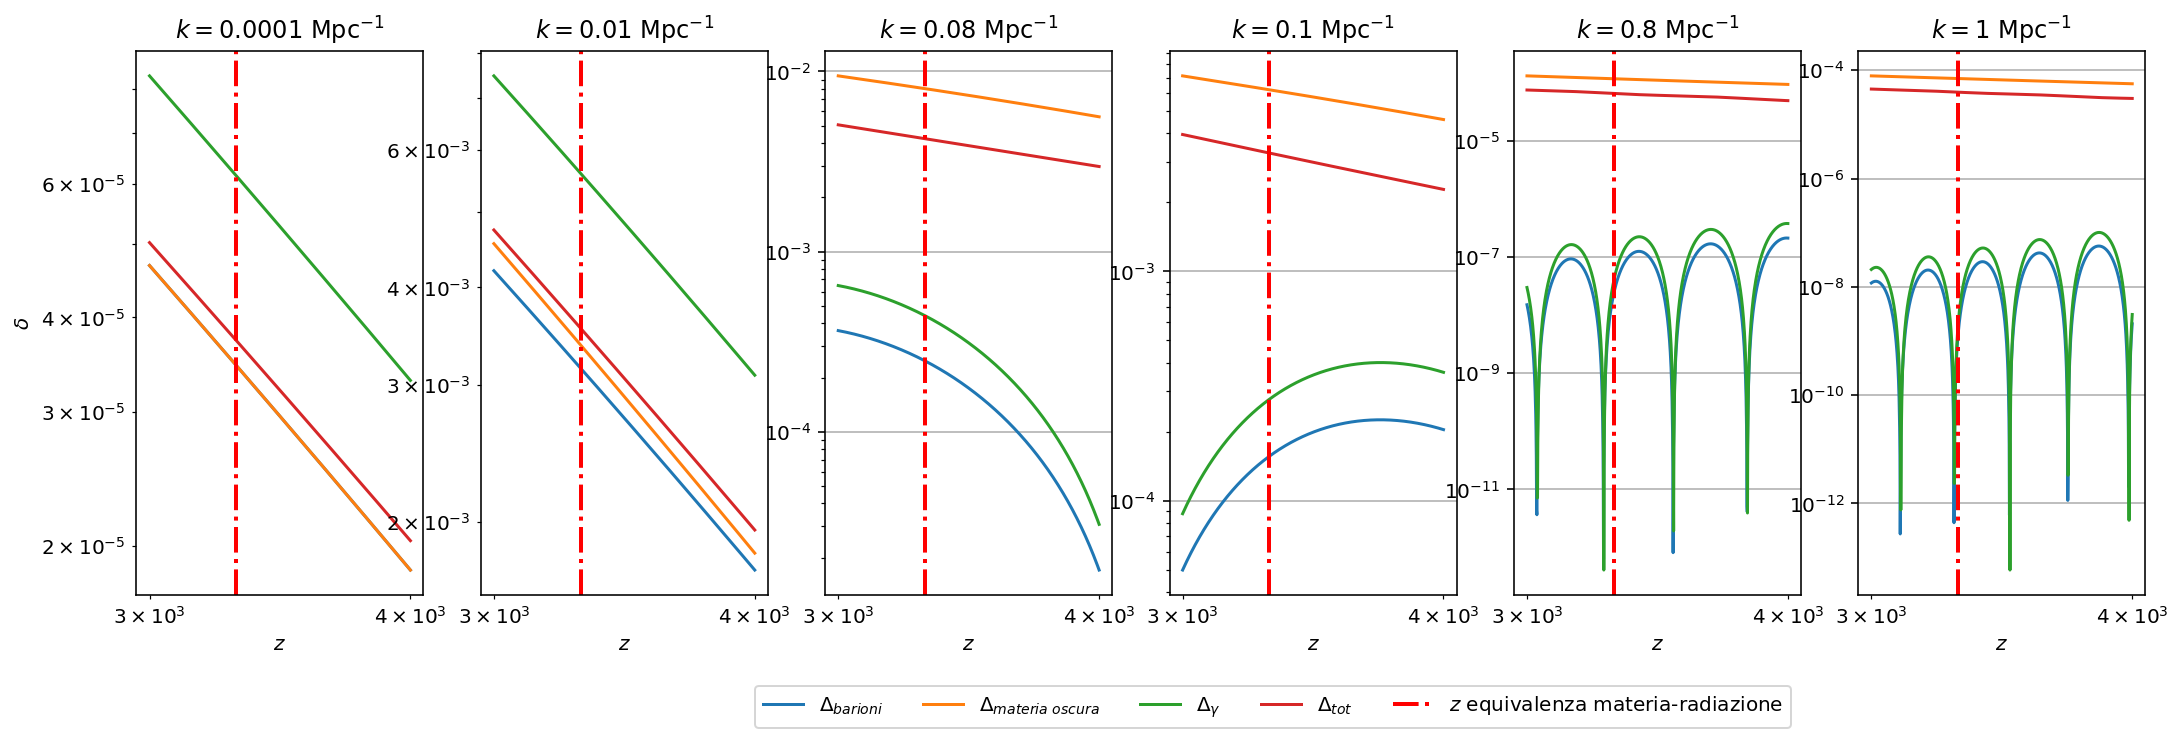

In [46]:
z = np.linspace(3000,4000,1000)
ks = [1e-4,1e-2,0.08,1e-1, 0.8,1]#0.001,0.1,1,100,0.01]
prefattore = 2.1 * 1e-9/np.array(ks)**3 * 2 * np.pi**2
ev = data.get_redshift_evolution(ks, z, ['delta_baryon','delta_cdm', 'delta_photon','delta_tot'])
_, axs= plt.subplots(1,len(ks), figsize=(18,5))
#print(ev)
for i, ax in enumerate(axs):
    ax.loglog(z,ev[i,:, 0]**2*prefattore[i])
    ax.loglog(z,ev[i,:, 1]**2*prefattore[i])
    ax.loglog(z,ev[i,:, 2]**2*prefattore[i])
    ax.loglog(z,ev[i,:, 3]**2*prefattore[i])
    ax.axvline(1+3300,0,1e4,ls='-.',color='red',lw=2,)
    
    ax.grid()
    ax.set_title(r'$k= %s \ \rm{Mpc^{-1}}$'%ks[i])
    ax.set_xlabel('$z$');
axs[0].set_ylabel('$\delta$');
    
plt.legend([r'$\Delta_{barioni}$', r'$\Delta_{{materia \ oscura}}$', r'$\Delta_\gamma$',r'$\Delta_{tot}$','$z$ equivalenza materia-radiazione'], ncols=5,bbox_to_anchor=(-0.2,-0.15),);
plt.semilogx()

Ad alto redshift, prima dell'equivalenza radiazione - materia, gli effetti si distinguono in questo modo:

- Sopra l'orizzonte:
    - Tutte le perturbazioni (materia oscura, barionica, fotoni...) crescono e basta.
- Sotto l'orizzonte: 
    - Le perturbazioni di materia barionica e fotoni, essendo interagenti, oscillano. Le perturbazioni di materia crescono. 


[]

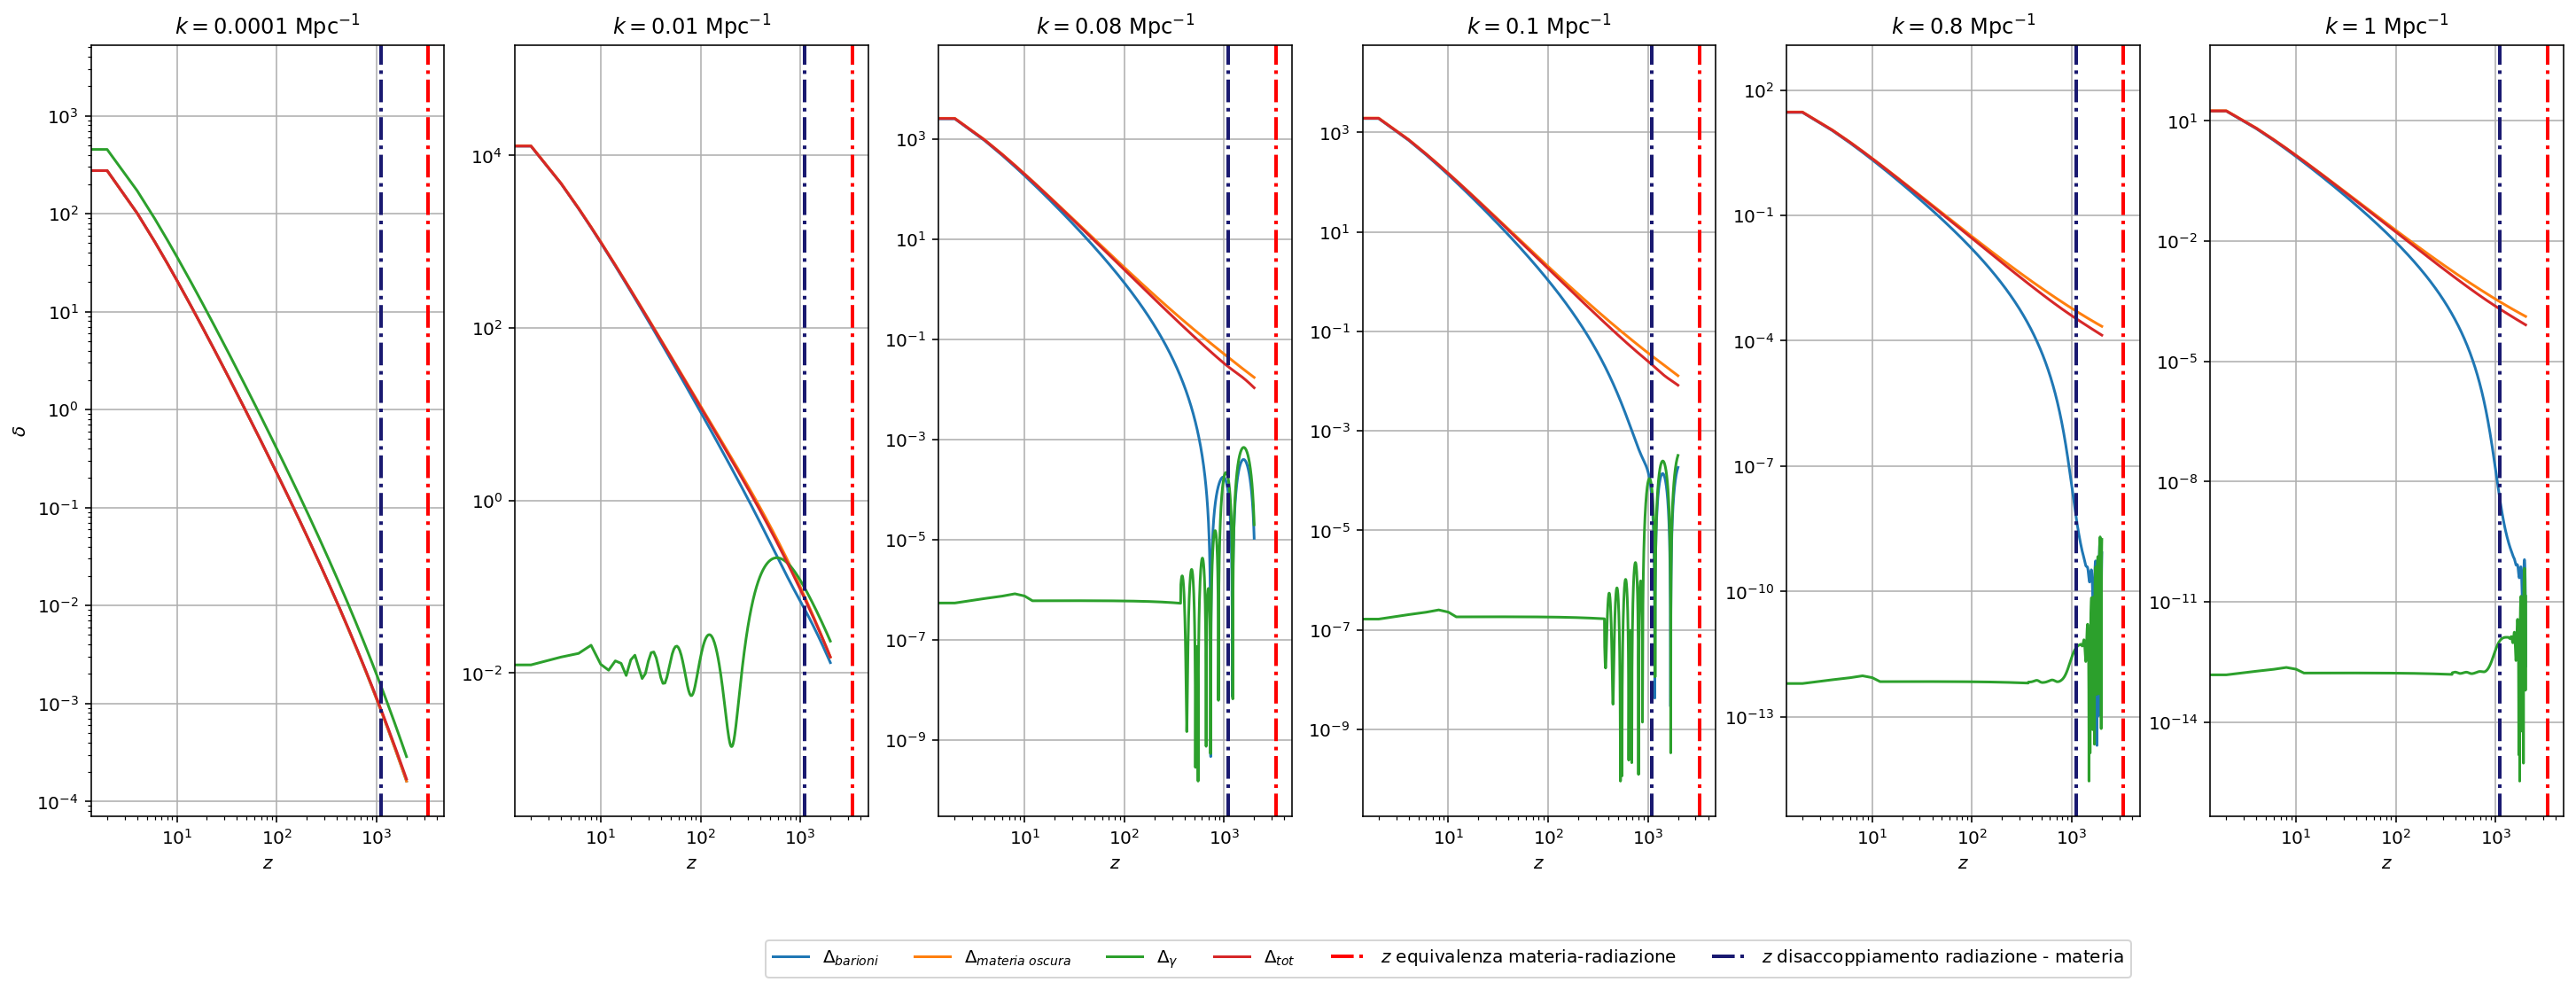

In [47]:
z = np.linspace(0,2000,1000)
ks = [1e-4,1e-2,0.08,1e-1, 0.8,1]#0.001,0.1,1,100,0.01]

ev = data.get_redshift_evolution(ks, z, ['delta_baryon','delta_cdm', 'delta_photon','delta_tot'])
_, axs= plt.subplots(1,len(ks), figsize=(25,8))
#print(ev)
for i, ax in enumerate(axs):
    ax.loglog(z,ev[i,:, 0]**2*prefattore[i])
    ax.loglog(z,ev[i,:, 1]**2*prefattore[i])
    ax.loglog(z,ev[i,:, 2]**2*prefattore[i])
    ax.loglog(z,ev[i,:, 3]**2*prefattore[i])
    ax.axvline(1+3300,0,1e4,ls='-.',color='red',lw=2,)
    ax.axvline(1+1100,0,1e4,ls='-.',color='midnightblue',lw=2,)
    
    ax.grid()
    ax.set_title(r'$k= %s \ \rm{Mpc^{-1}}$'%ks[i])
    ax.set_xlabel('$z$');
axs[0].set_ylabel('$\delta$');
    
plt.legend([r'$\Delta_{barioni}$', r'$\Delta_{{materia \ oscura}}$', r'$\Delta_\gamma$',r'$\Delta_{tot}$','$z$ equivalenza materia-radiazione','$z$ disaccoppiamento radiazione - materia'], ncols=6,bbox_to_anchor=(-0.2,-0.15),);
plt.semilogx()

A basso redshift, dopo l'equivalenza radiazione - materia, gli effetti si distinguono in questo modo:

- Sopra l'orizzonte:
    - Le perturbazioni (materia oscura, barionica, fotoni...) crescono uniformemente, ma meno sostenutamente che nell'epoca dominata dalla radiazione
- Sotto l'orizzonte: 
    - Le perturbazioni di materia barionica e fotoni si disaccoppiano progressivamente, le perturbazioni dei fotoni decadono e si dissipano, le perturbazioni di materia barionica progressivamente si riallineano alle perturbazioni di materia oscura, recando memoria delle oscillazioni acustiche barioniche. Le perturbazioni di materia oscura crescono, anche se ad un tasso meno sostenuto che nell'epoca dominata dalla radiazione, e inducono una simile crescita nella materia barionica


L'andamento delle perturbazioni in redshift si traduce nell'andamento per scala riassunto dallo spettro di potenza. Man mano che il tempo passa, più scale entrano nell'orizzonte e lo spettro di potenza viene smorzato da destra (piccole scale) a sinistra, con la contemporanea progressiva attivazione delle oscillazioni acustiche. 

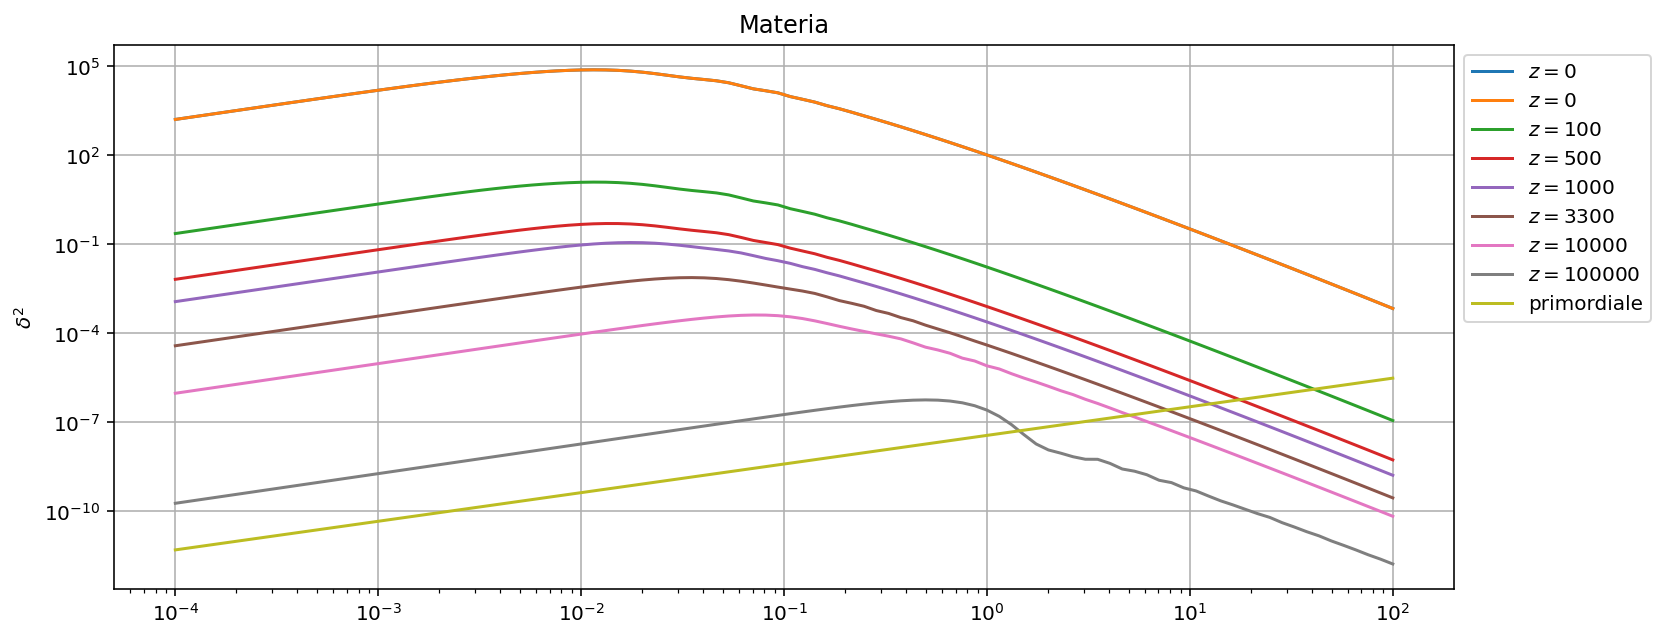

In [48]:
redshift = np.array([0,1e-4,100,500, 1000,3300,1e4,1e5])#np.array([4000, 3000, 1000, 500, 0])
scale = np.logspace(-4,2,100)
prefattore = 2.1 * 1e-9/scale**3 * 2 * np.pi**2
pk_primordiale = results.Params.scalar_power(scale)

indice_p_max = np.zeros(len(redshift))

plt.figure(figsize=(12,5))

plt.title('Materia')

for j, redshifts in enumerate(redshift):
    spettro = np.array(data.get_redshift_evolution(scale, redshifts, ['delta_tot']).flatten()**2)*prefattore
    plt.loglog(scale,spettro, label = r'$z= %s $'%int(redshifts) )
    #print(np.where(spettro == np.max(spettro)))
    indice_p_max[j] = int(np.where(spettro == np.max(spettro))[0])
plt.ylabel(r'$k \ [Mpc^{-1} \ h ]$')
plt.ylabel(r'$\delta^2$')

plt.loglog(scale,pk_primordiale * scale ** 4 / (scale**3/(2*np.pi**2)),label='primordiale')

plt.legend(ncols=1,bbox_to_anchor=(1,1),)
   
plt.grid()

Text(0, 0.5, '$k \\ [Mpc^{-1} \\ h ]$')

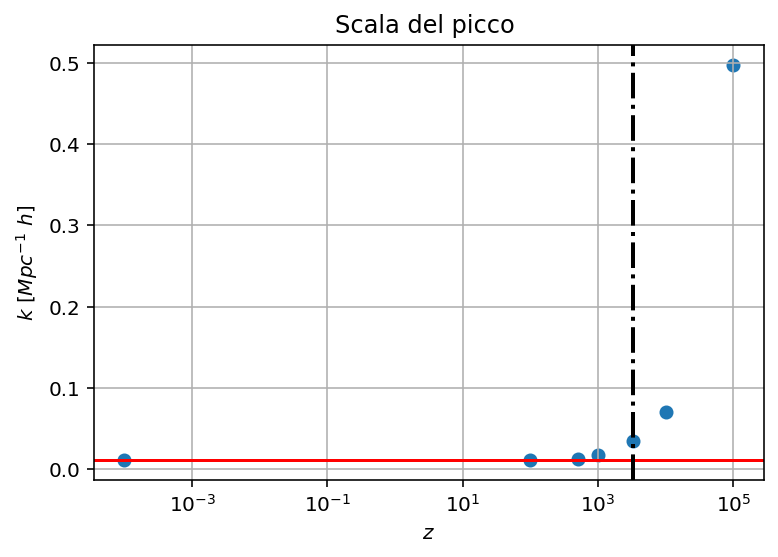

In [49]:
plt.title('Scala del picco ')
plt.scatter(redshift,[scale[int(index)] for index in indice_p_max])
plt.axhline(scale[int(indice_p_max[0])],0,np.max(redshift),ls='-',color='red')
plt.axvline(1+3300,0,1e4,ls='-.',color='black',lw=2,)

plt.semilogx()
plt.grid()
plt.xlabel(r'$z$')
plt.ylabel(r'$k \ [Mpc^{-1} \ h ]$')
    

Il picco dello spettro si sposta verso scale più grandi (verso sinistra) fino all'equivalenza radiazione materia o per redshift poco più bassi (nessun effetto fisico è davvero istantaneo!), poi si stabilizza perché le perturbazioni crescono tutte assieme, senza differenza tra l'essere sopra o sotto l'orizzonte.  

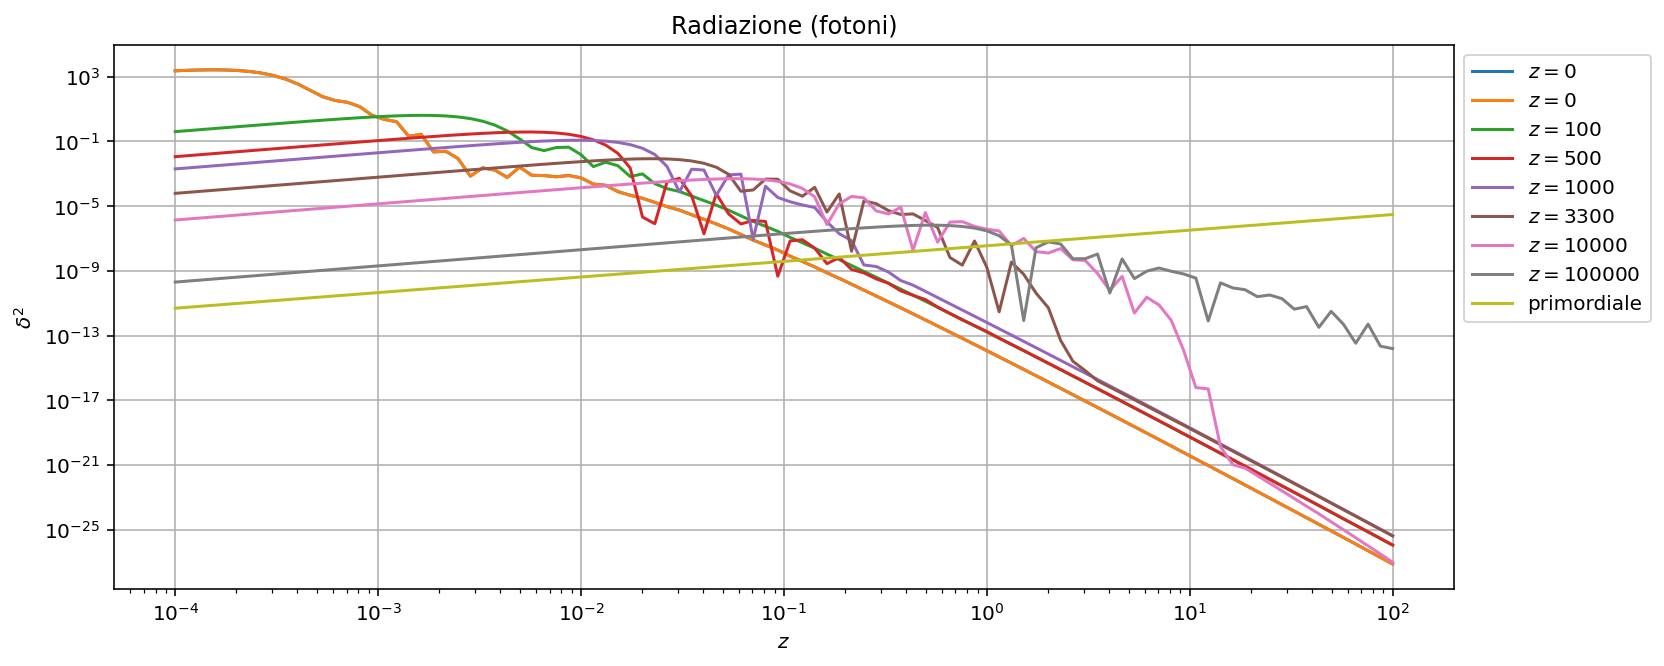

In [50]:
redshift = np.array([0,1e-4,100,500, 1000,3300,1e4,1e5])#np.array([4000, 3000, 1000, 500, 0])
scale = np.logspace(-4,2,100)
prefattore = 2.1 * 1e-9/scale**3 * 2 * np.pi**2
pk_primordiale = results.Params.scalar_power(scale)

indice_p_max = np.zeros(len(redshift))

plt.figure(figsize=(12,5))

plt.title('Radiazione (fotoni)')

for j, redshifts in enumerate(redshift):
    spettro = np.array(data.get_redshift_evolution(scale, redshifts, ['delta_photon']).flatten()**2)*prefattore
    plt.loglog(scale,spettro, label = r'$z= %s $'%int(redshifts) )
    indice_p_max[j] = int(np.where(spettro == np.max(spettro))[0])

plt.loglog(scale,pk_primordiale * scale ** 4 / (scale**3/(2*np.pi**2)),label='primordiale')

plt.legend(ncols=1,bbox_to_anchor=(1,1),)
plt.xlabel(r'$z$')
plt.ylabel(r'$\delta^2$')
  
plt.grid()

La fenomenologia di un fluido relativistico è ben diversa: le perturbazioni crescono al decrescere del redshift, ma i fotoni non formano struttura. Quando le distanze sono diventate troppo grandi perché fotoni e barioni possano interagire ( $z\sim 1100$, epoca del disaccoppiamento e della formazione della CMB) i fotoni sono liberi di muoversi per tutto l'universo, "sparpagliandosi" in modo praticamente uniforme (free streaming). Le oscillazioni vengono a loro volta progressivamente smorzate e ogni forma di correlazione (=struttura) viene persa (i valori in ordinata dello spettro di potenza sono ben più piccoli dello spettro di materia).

## Evoluzione dei potenziali e della materia nell'universo

Le prossime due celle mostrano un video, anzi, un film, un film tanto semplice quanto può essere la modellizzazione fisica -- che riesce a ricondurre fenomeni complessi ad una quantità ridotta ('riduzionismo') di concetti elementari (potenziali, velocità, densità degli elementi del sistema...) --  quanto incredibilmente ricco e significativo, a mio parere di folgorante bellezza: la storia dell'universo, delle strutture che si formano, al passare del tempo, "narrata" a partire dall'evoluzione dei potenziali gravitazionali. 

Può apparire incredibilmente semplice, ma le forze concorrenti nell'universo sono fondamentalmente di tre categorie soltanto:
- La gravità, onnipresente e interagente con tutte le specie di materia che compongono l'universo
- Le forze di pressione e la termodinamica associata, che regola il comportamento dei gas a piccole e medie scale, determinando la formazione di stelle e galassie: come immense pentole a pressione, che si oppongono alla gravità che cerca di comprimerli, i gas barionici resistono al collasso, fino a quando non si sono raffreddati a sufficienza.
- I campi magnetici, la cui natura a queste grandi scale resta ancora non del tutto compresa, che contribuiscono alla formazione delle strutture imponendo, con le loro linee di forza, traiettorie alle particelle e contribuendo a fenomeni di dissipazione ('di attrito') e turbolenza, trasferendo energia da scale grandi a scale piccole e viceversa.

In [51]:
# Per quello che interessa a noi, tutto quello che segue è solo codice preparatorio, senza un vero interesse
# per il significato delle varie operazioni svolte.

data= camb.get_results(pars)

zstar=data.get_derived_params()['zstar']
etastar=data.conformal_time(zstar)
eta = np.logspace(-1.7,np.log10(etastar),400)
k=10**np.linspace(-3,1,1200)

z = data.redshift_at_conformal_time(eta)
back_ev = data.get_background_time_evolution(eta, ['x_e', 'visibility'])
x_e=back_ev['x_e']
vis=back_ev['visibility']
adotoa = data.h_of_z(z)/(1+z)  # 
rho=data.get_background_densities(1/(1+z))
Rmat=(rho['baryon']+rho['cdm'])/(rho['photon']+rho['neutrino']+rho['nu'])

grhonu=data.grhormass[0]+data.grhornomass
Rv=grhonu/(grhonu+data.grhog)
omega = (data.grhob+data.grhoc)/np.sqrt(3*(data.grhog+grhonu))
Psi_init = -10/(4*Rv+15)

import camb.symbolic as cs

ev=data.get_time_evolution(k, eta, [cs.Psi_N, 
                                    'delta_photon', 
                                    cs.make_frame_invariant(cs.Delta_g, 'Newtonian'), 
                                    cs.make_frame_invariant(cs.v_b, 'Newtonian') 
                                   ], lAccuracyBoost=4)
Psi = ev[:,:,0]
Delta_g = ev[:,:,1]
Delta_g_N=ev[:,:,2]
v_b_N = ev[:,:,3]

for i, etai in enumerate(eta):
    for j, kj in enumerate(k):
        if etai*kj < 0.1 and etai*omega < 0.1:
            Psi[j,i]=Psi_init - 25/8*omega*etai *(8*Rv-3)/(4*Rv+15)/(2*Rv+15)
            Delta_g_N[j,i] = Delta_g[j,i] - 4*adotoa[i]*( Psi_init/2*etai - 15*omega*etai**2/8*(4*Rv-5)/(4*Rv+15)/(2*Rv+15))


In [52]:
#pip install ffmpeg-python # decommentami su un altro computer per installare 

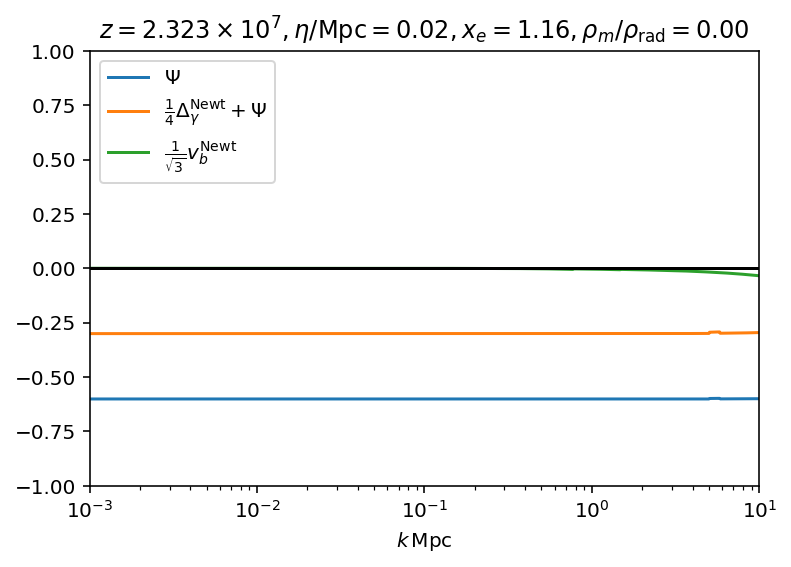

In [53]:
# Anche qui, preparazione e plot, a noi interessa soprattutto il video, 

import math
from matplotlib import animation

def latex_sci_format(num, dec=3):
    return "{:.{dec}f}\\times 10^{{{}}}".format(num / (10 ** int(math.floor(math.log10(abs(num))))), int(math.floor(math.log10(abs(num)))), dec=dec)

fig, ax = plt.subplots()

plot_vars = {r'$\Psi$':Psi, 
             r'$\frac{1}{4}\Delta^{\rm Newt}_\gamma +\Psi$': Delta_g_N/4+Psi, 
             r'$\frac{1}{\sqrt{3}}v_b^{\rm Newt}$': v_b_N/np.sqrt(3) }

anim_fps=8

lines=[]
for lab in plot_vars.keys():
    line, = ax.semilogx([], [], label=lab)
    lines.append(line)
    
ax.axhline(0,color='k')
plt.legend(loc='upper left')

ax.set_xlim(k[0], k[-1])
ax.set_ylim(-1, 1)
ax.set_xlabel(r'$k\, {\rm Mpc}$')

# Define the update function
def update(i):
    ax.set_title( r'$z= %s, \eta/{\rm Mpc}= %.2f, x_e = %.2f, \rho_m/\rho_{\rm rad}=%.2f$' 
                  % (latex_sci_format(z[i]), eta[i], x_e[i], Rmat[i]))
    for line, var in zip(lines,plot_vars.values()):
        line.set_data(k, var[:, i])
    return lines

# Create the animation
transfer_anim =animation.FuncAnimation(fig, update, frames=range(len(eta)),  blit=True)
#writer = animation.writers['ffmpeg'](fps=anim_fps, bitrate=-1)

# can save like this
#transfer_anim.save(r'Newtonian_transfer_evolve_monopole_phi_vb.mp4', writer=writer, dpi=240)

See the output mp4 file [here](https://cdn.cosmologist.info/antony/Newtonian_transfer_evolve_monopole_phi_vb.mp4) or play below:

<video width="600" 
       src="https://cdn.cosmologist.info/antony/Newtonian_transfer_evolve_monopole_phi_vb.mp4"  
       controls>
</video>

Il video sopra è molto denso: mostra il comportamento dei potenziali gravitazionali ($\Psi$), del monopolo delle perturbazioni dei fotoni ($\frac{1}{4}\Delta^{\rm Newt}_\gamma +\Psi$', la stessa quantità che appare nella CMB), accoppiati ai barioni, e del dipolo della CMB, funzione della velocità dei barioni, al variare del redshift (che decresce, cioè parte da un universo molto primordiale e arriva fino alla formazione della CMB a z $\sim$ 1100) e delle velocità dei barioni $\frac{1}{\sqrt{3}}v_b^{\rm Newt}$.

- $\eta$ è una "coordinata temporale", 1 unità vale circa 1000 anni (e infatti il video si arresta a circa 300 mila anni dopo il Big Bang, quando si forma la CMB)
- $x_e$ ci dà la frazione di ionizzazione del plasma, che a sua volta decresce (molto rapidamente, solo quando ci avviciniamo alla formazione della CMB) man mano che gli elettroni si legano ai nuclei atomici, rendendo l'universo trasparente e trasformando il fluido cosmico da plasma (stato della materia in cui gli elettroni sono liberi) a gas di barioni, fotoni, neutrini e materia oscura
- Il rapporto tra la densità della materia $\rho_m$ e della radiazione elettromagnetica $\rho_{rad}$, che a sua volta aumenta con il redshift, man mano che la radiazione si disaccoppia dal fluido cosmico e la sua densità decresce.

Si noti:
- Le oscillazioni nei barioni e nella radiazione, ma anche nella materia oscura (i potenziali blu!), queste ultime limitate ad una brevissima fase ad alto redshift!
- Come i potenziali si propaghino progressivamente a scale sempre più grandi (k sempre più piccoli), l'informazione si "propaga" al decrescere del redshift e alla velocità della luce
- I potenziali sono negativi là dove c'è struttura (sovradensità), e si annullano dove invece è tutto uniforme; si ricordi infatti che il potenziale è negativo là dove l'attrazione gravitazionale è più intensa. Si noti che a grandi scale - e a redshift molto alti - i potenziali sono costanti nel tempo.
- Le velocità oscillano da positive (allontanamento dei barioni dalle sorgenti dei potenziali gravitazionali) a negative (avvicinamento dei barioni alle sorgenti dei potenziali gravitazionali).

In [54]:
# Si può anche eseguire a parte in questa cella
from IPython.display import display, Video
video = transfer_anim.to_html5_video()
display(Video(data=video, embed=True, width = 600))

In [55]:
# Il codice sotto si concentra sui soli potenziali gravitazionali e i valori del contrasto di densità, e genera nuovamente
# un video.

eta=np.logspace(-1.7,np.log10(data.tau0),500)[:-1]
k=10**np.linspace(-3,2,2000)
z = data.redshift_at_conformal_time(eta)
import camb.symbolic as cs
ev=data.get_time_evolution(k, eta, [cs.Psi_N,
                                    'delta_cdm', # sychronous gauge cdm perturbation
                                    'delta_photon', 
                                    'delta_baryon'], lAccuracyBoost=4)

Psi = ev[:,:,0]
Delta_c = ev[:,:,1]
Delta_g=ev[:,:,2]
Delta_b=ev[:,:,3]

x_e = data.get_background_time_evolution(eta, ['x_e'])['x_e']
adotoa = data.h_of_z(z)/(1+z)  # comoving Hubble
rho=data.get_background_densities(1/(1+z))
Rmat=(rho['baryon']+rho['cdm'])/(rho['photon']+rho['neutrino']+rho['nu'])
zstar=data.get_derived_params()['zstar']

# series for super-horizon Psi
grhonu=data.grhormass[0]+data.grhornomass
Rv=grhonu/(grhonu+data.grhog)
omega = (data.grhob+data.grhoc)/np.sqrt(3*(data.grhog+grhonu))
# initial value of super-horizon Psi for unit curvature and no isocurvature
Psi_init = -10/(4*Rv+15)
for i, etai in enumerate(eta):
    for j, kj in enumerate(k):
        if etai*kj < 0.1 and etai*omega < 0.1:
            Psi[j,i]=Psi_init - 25/8*omega*etai *(8*Rv-3)/(4*Rv+15)/(2*Rv+15)

/tmp/ipykernel_9509/1669222679.py:12: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_xlim(k[0], k[-1])


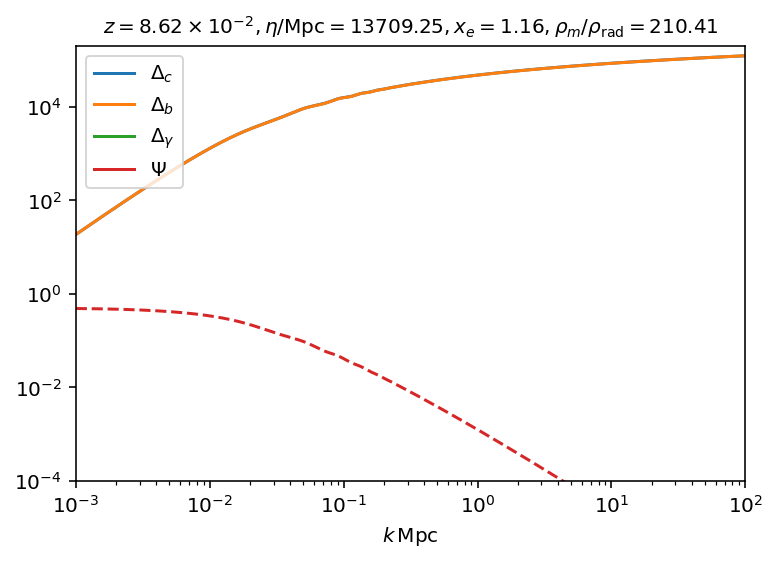

In [56]:
fig, ax = plt.subplots()
plot_vars = {r'$\Delta_c$': Delta_c, r'$\Delta_b$': Delta_b,
             r'$\Delta_\gamma$': Delta_g,r'$\Psi$': Psi}             
anim_fps=8
lines=[]
for lab in plot_vars.keys():
    line, = ax.loglog([], [], label=lab)
    lines.append(line)

plt.axhline(0, ls='-', color='k')
plt.legend(loc='upper left')
ax.set_xlim(k[0], k[-1])
ax.set_xlabel(r'$k\, {\rm Mpc}$')

ax.set_ylim(1e-4, 2e5)
lines.append(ax.loglog([], [],ls='--', color='C1')[0])
lines.append(ax.loglog([], [],ls='--', color='C2')[0])
lines.append(ax.loglog([], [],ls='--', color='C3')[0])
    
# Define the update function
def update(i):
    ax.set_title( r'$z= %s, \eta/{\rm Mpc}= %.2f, x_e = %.2f, \rho_m/\rho_{\rm rad}=%.2f$' 
                  % (latex_sci_format(z[i],2), eta[i], x_e[i], Rmat[i]), fontsize=10)

    for line, var in zip(lines,plot_vars.values()):
        line.set_data(k, var[:, i])
    lines[-3].set_data(k,-Delta_b[:, i])
    lines[-2].set_data(k,-Delta_g[:, i])
    lines[-1].set_data(k,-Psi[:, i])
        
    if z[i] < zstar: # hide photons after recombination as irrelevant for matter
        lines[2].set_data([],[]) 
        lines[-2].set_data([],[])      
    return lines

# Create the animation
transfer_anim =animation.FuncAnimation(fig, update, frames=range(len(eta)),  blit=True, repeat = False)
writer = animation.writers['ffmpeg'](fps=anim_fps, bitrate=-1)
transfer_anim.save(r'matter_transfer_evolve_sync.mp4', writer=writer, dpi=240)

This the video produced of the synchronous transfer function evolution (dashed lines are negative):

<video width="600" 
       src="https://cdn.cosmologist.info/antony/matter_transfer_evolve_sync.mp4"  
       controls>
</video>

Il video può essere visto andando all'ultima cella di questo sito https://camb.readthedocs.io/en/latest/CAMBdemo.html

Il video è molto simile al precedente: più nel dettaglio, vediamo i valori di contrasto di densità $\Delta$ delle varie specie di materia e radiazione.
Si noti che:
- I fotoni $\Delta_{g}$ diminuiscono sempre più la loro densità rispetto al background al decrescere del tempo (per loro è appropriatissima una descrizione lineare), e si disaccoppiano dai potenziali (free streaming, "sparpagliamento").
- Le perturbazioni di materia barionica $\Delta_b$ oscillano accoppiate ai fotoni fino a $z\sim1000$, poi si disaccoppiano dai fotoni e ricominciano a crescere e riallinearsi alle perturbazioni di materia oscura. 
- Le perturbazioni di materia oscura $\Delta_c$ crescono senza interagire con il resto della materia (non oscillano)

# Fit dell'  "Ampiezza delle BAO" con due modelli diversi

Temi: BAO, misura di $H_{0}$, righelli e candele standard, tensioni, inferenza statistica, cross-correlazioni, bias e traccianti.

Lo spettro di potenza non ci racconta soltanto la storia nel tempo e la struttura nello spazio dell'universo: è anche un fondamentale **strumento di misura**, che consente di ricavare una serie di quantità fondamentali per il modello $\Lambda$CDM: in particolare, la varianza delle fluttuazioni entro un raggio di 8 Mpc, $\sigma_8$, il parametro di densità della materia $\Omega_{m}$ dalla scala del picco (o punto di inversione, o turnover) e, dalle oscillazioni acustiche barioniche, misurare indirettamente il valore della costante di Hubble $H_{0}$. 
Il fatto che sia le BAO sia il punto di inversione siano legati a distanze invarianti è la ragione del nome che viene loro solitamente dato di "righelli standard". Sono indicatori di distanza a grandissima scala che si comportano in modo analogo alle "candele standard" dell'universo locale (Cefeidi, Supernove Ia...), oggetti la cui luminosità intrinseca è nota e di cui, data la luminosità apparente misurata a terra, è possibile calcolare la distanza e calibrare la scala delle distanze cosmologiche. 

La scala tipica delle oscillazioni acustiche barioniche, 150 Mpc, è il più grande righello standard a nostra disposizione al momento del quale disponiamo da una quindicina d'anni di misure. La misura di $H_0$ che si ottiene non è però indipendente: è bensì funzione (si dice "degenere") del valore dell'orizzonte acustico $r_s$ che viene misurato con la radiazione cosmica di fondo, che va quindi fissato indipendentemente. In alternativa, si può misurare il *rapporto* tra la loro dimensione radiale ed angolare, ricorrendo alle candele standard nell'universo "locale" (basso redshift, $z$ compreso tra  0 e 2 da contrastare con $z=1100$ della CMB). Questo impedisce però di misurare direttamente $H_{0}$; per ritrovarla, dobbiamo imporre un modello di cosmologia, con 
i parametri nuovamente fissati dalla CMB. 

Quello che risulta però è che le due misure di $H_0$ sono ad oggi in *tensione*: la CMB ci fornisce un valore (ottenuto direttamente, ma a partire da un'osservabile "complicata" come lo spettro della radiazione cosmica di fondo) più basso, $67.66\pm0.42$ $\rm{km  \ s ^{-1} \  Mpc^{-1}}$, rispetto al valore di $73.04\pm1.04$  $\rm{km \ s ^{-1} \ Mpc^{-1}}$ ottenuto indirettamente, ma a partire da più semplici misure di distanza di oggetti astrofisici. 

Una simile tensione, ma più debole, si osserva anche sulla normalizzazione dello spettro di potenza $\sigma_8$, che risulta invece più grande per la CMB e più piccola per lo spettro di potenza misurato con la struttura a grande scala.

Ma che cosa vuol dire che due misure fisiche sono "in tensione"? Per capirlo, tenteremo per prima cosa il fit dello spettro di potenza ed una misura indiretta delle oscillazioni acustiche barioniche, con il cosiddetto formalismo di Alcock-Paczinski. 

L'idea è la seguente: se la nostra misura di distanza, dipendente dal modello cosmologico "fiduciale", è affidabile, allora la dipendenza dello spettro di potenza da $k$ può essere parametrizzata in questo modo: $P(k) = P(k/\alpha)$. I dati delle misure devono disporsi allora sulla curva in modo tale che tale curva riproduca lo spettro di potenza teorico; questo è vero solo se  $\alpha = 1$. Ma questo vuol dire, indirettamente, che il valore di $H_{0}$ che stiamo assumendo non è corretto. 

Di seguito, non ricaveremo $H_{0}$, che richiede tempo ed è complesso, ci limiteremo soltanto a trovare il valore di $\alpha$. Vedremo però che ogni dato fisico è affetto da incertezza, e questa incertezza rende la situazione più sfumata: non si può dire in assoluto che una misura sia "giusta" o "sbagliata", va confrontata con le incertezze, e questo implica il confronto tra modelli, ed il nostro grado di fiducia in essi, così come la nostra necessità di misure sempre più precise ed accurate, per scartare quante più alternative possibili. 

Questo tipo di ragionamento si chiama inferenza statistica, ed è fondamentale in ogni branca della fisica: è il nostro unico criterio di verità, che combina matematica, statistica, precisione e buon senso, tutti strumenti fondamentali per fare il fisico!




In [57]:
# Visualizzazione fit dei dati 

from getdist import plots, MCSamples
import getdist


In [58]:
k_data = kbins[kbins <= 1] #taglio i dati rumorosi a grandi scale, che comunque non servono

In [59]:
cut_index_in = 0 ##np.where((hm.k_hm >= 2*1e-2 ) & (hm.k_hm <= 1))[0][0]
cut_index_fin = np.where(kbins <= 1)[0][-1]

# "Template fitting"

In [60]:
# Il nostro modello di spettro ha due componenti: un termine con le BAO e uno senza.

spettro_BAO = hm_ref # quello con le BAO è l'halo model...


In [61]:
hm_ref.z

0.0

In [62]:
# Quello senza BAO è costruito con l'halo model, ma cambiamo la funzione di trasferimento. 

spettro_noBAO = DMHaloModel()

spettro_noBAO.transfer_model = 'EH_NoBAO'

spettro_noBAO.tracer_profile_model = "NFW" # Primo ingrediente: profilo di densità dell'alone di materia oscura
# Navarro - Frenk - White, lo standard più comune

spettro_noBAO.bias_model = 'ST99'  # Secondo ingrediente, il "bias dell'alone"

spettro_noBAO.hmf_model = 'ST' # Terzo ingrediente: la funzione di massa, quanti (in numero) aloni abbiamo nell'universo per ogni valore di massa dell'alone?

# Modello da contrastare

Modello basato su parametri cosmologici alternativi, in particolare, diverso $H_{0}$, diverso $\Omega_{\rm{materia \ oscura},0}$

In [63]:
pk_contrasto_BAO = DMHaloModel()

pk_contrasto_BAO.z = hm_ref.z

pk_contrasto_BAO.tracer_profile_model = "NFW" # Primo ingrediente: profilo di densità dell'alone di materia oscura
# Navarro - Frenk - White, lo standard più comune

pk_contrasto_BAO.bias_model = 'ST99'  # Secondo ingrediente, il "bias dell'alone"

pk_contrasto_BAO.hmf_model = 'ST' # Terzo ingrediente: la funzione di massa, quanti (in numero) aloni abbiamo nell'universo per ogni valore di massa dell'alone?

pk_contrasto_BAO.cosmo_params = {
        'H0': 67.0,
    'Om0':0.15
    
    }
pk_contrasto_BAO.sigma_8 = 0.68#spettro_BAO.sigma_8#0.68

In [64]:
pk_contrasto_noBAO = DMHaloModel()

redshift = 0.

pk_contrasto_noBAO.z = redshift

pk_contrasto_noBAO.tracer_profile_model = "NFW" # Primo ingrediente: profilo di densità dell'alone di materia oscura
# Navarro - Frenk - White, lo standard più comune

pk_contrasto_noBAO.bias_model = 'ST99'  # Secondo ingrediente, il "bias dell'alone"

pk_contrasto_noBAO.hmf_model = 'ST' # Terzo ingrediente: la funzione di massa, quanti (in numero) aloni abbiamo nell'universo per ogni valore di massa dell'alone?

pk_contrasto_noBAO.cosmo_params = {
        'H0': 75.0,
    'Om0':0.15,
    

        
    }
pk_contrasto_noBAO.transfer_model = 'EH_NoBAO'
pk_contrasto_noBAO.sigma_8 = 0.68#spettro_BAO.sigma_8#0.68

Fin qui, abbiamo generato i dati, le nostre "osservazioni" del mondo fisico. Questi però sono viziati da incertezze, che possono dipendere da effetti strumentali o astrofisici sottraibili a posteriori, noti e solitamente sottratti o quantificati a parte, gli errori sistematici, e residui errori di misura che, nel caso della cosmologia, combinano proprietà statistiche dei dati e delle misure e proprietà fisiche (con un pizzico in più di statistica nel caso della cosmologia, ricordiamo che lo spettro di potenza è una misura di una correlazione statistica!). 
Per semplicità, le incertezze che creo nella prossima cella non sono quelle che effettivamente si assegnano alle osservazioni, ma costruite manualmente e assolutamente "finte", solo per poterci poi ragionare sopra.

Ciò che è fondamentale tenere a mente è però questo concetto: **sono le dimensioni delle incertezze che ci consentono di distinguere ("risolvere") tra diversi modelli fisici, perché più queste sono grandi più, intuitivamente, diversi modelli saranno compatibili ("fitteranno") i dati**. (Nota: to fit, in inglese, vuol dire appunto essere adatto, appropriato, in forma!)

In [65]:
# Genero delle finte incertezze sui dati, per riprodurre il tipico andamento a fisarmonica ho trovato questa combinazione 

uncert = hm_ref.power_auto_matter_fnc(kbins)**0.7*kbins + hm_ref.power_auto_matter_fnc(kbins)*np.exp(-kbins*30) 

/home/andrea/anaconda3/envs/progetto_1/lib/python3.11/site-packages/halomod/tools.py:653: UserWarning: You are using an un-normalized mass function and bias function pair.Bias ST99 has the following paired HMF model: (<class 'hmf.mass_function.fitting_functions.SMT'>,). Matter correlations are not well-defined.
  warnings.warn(


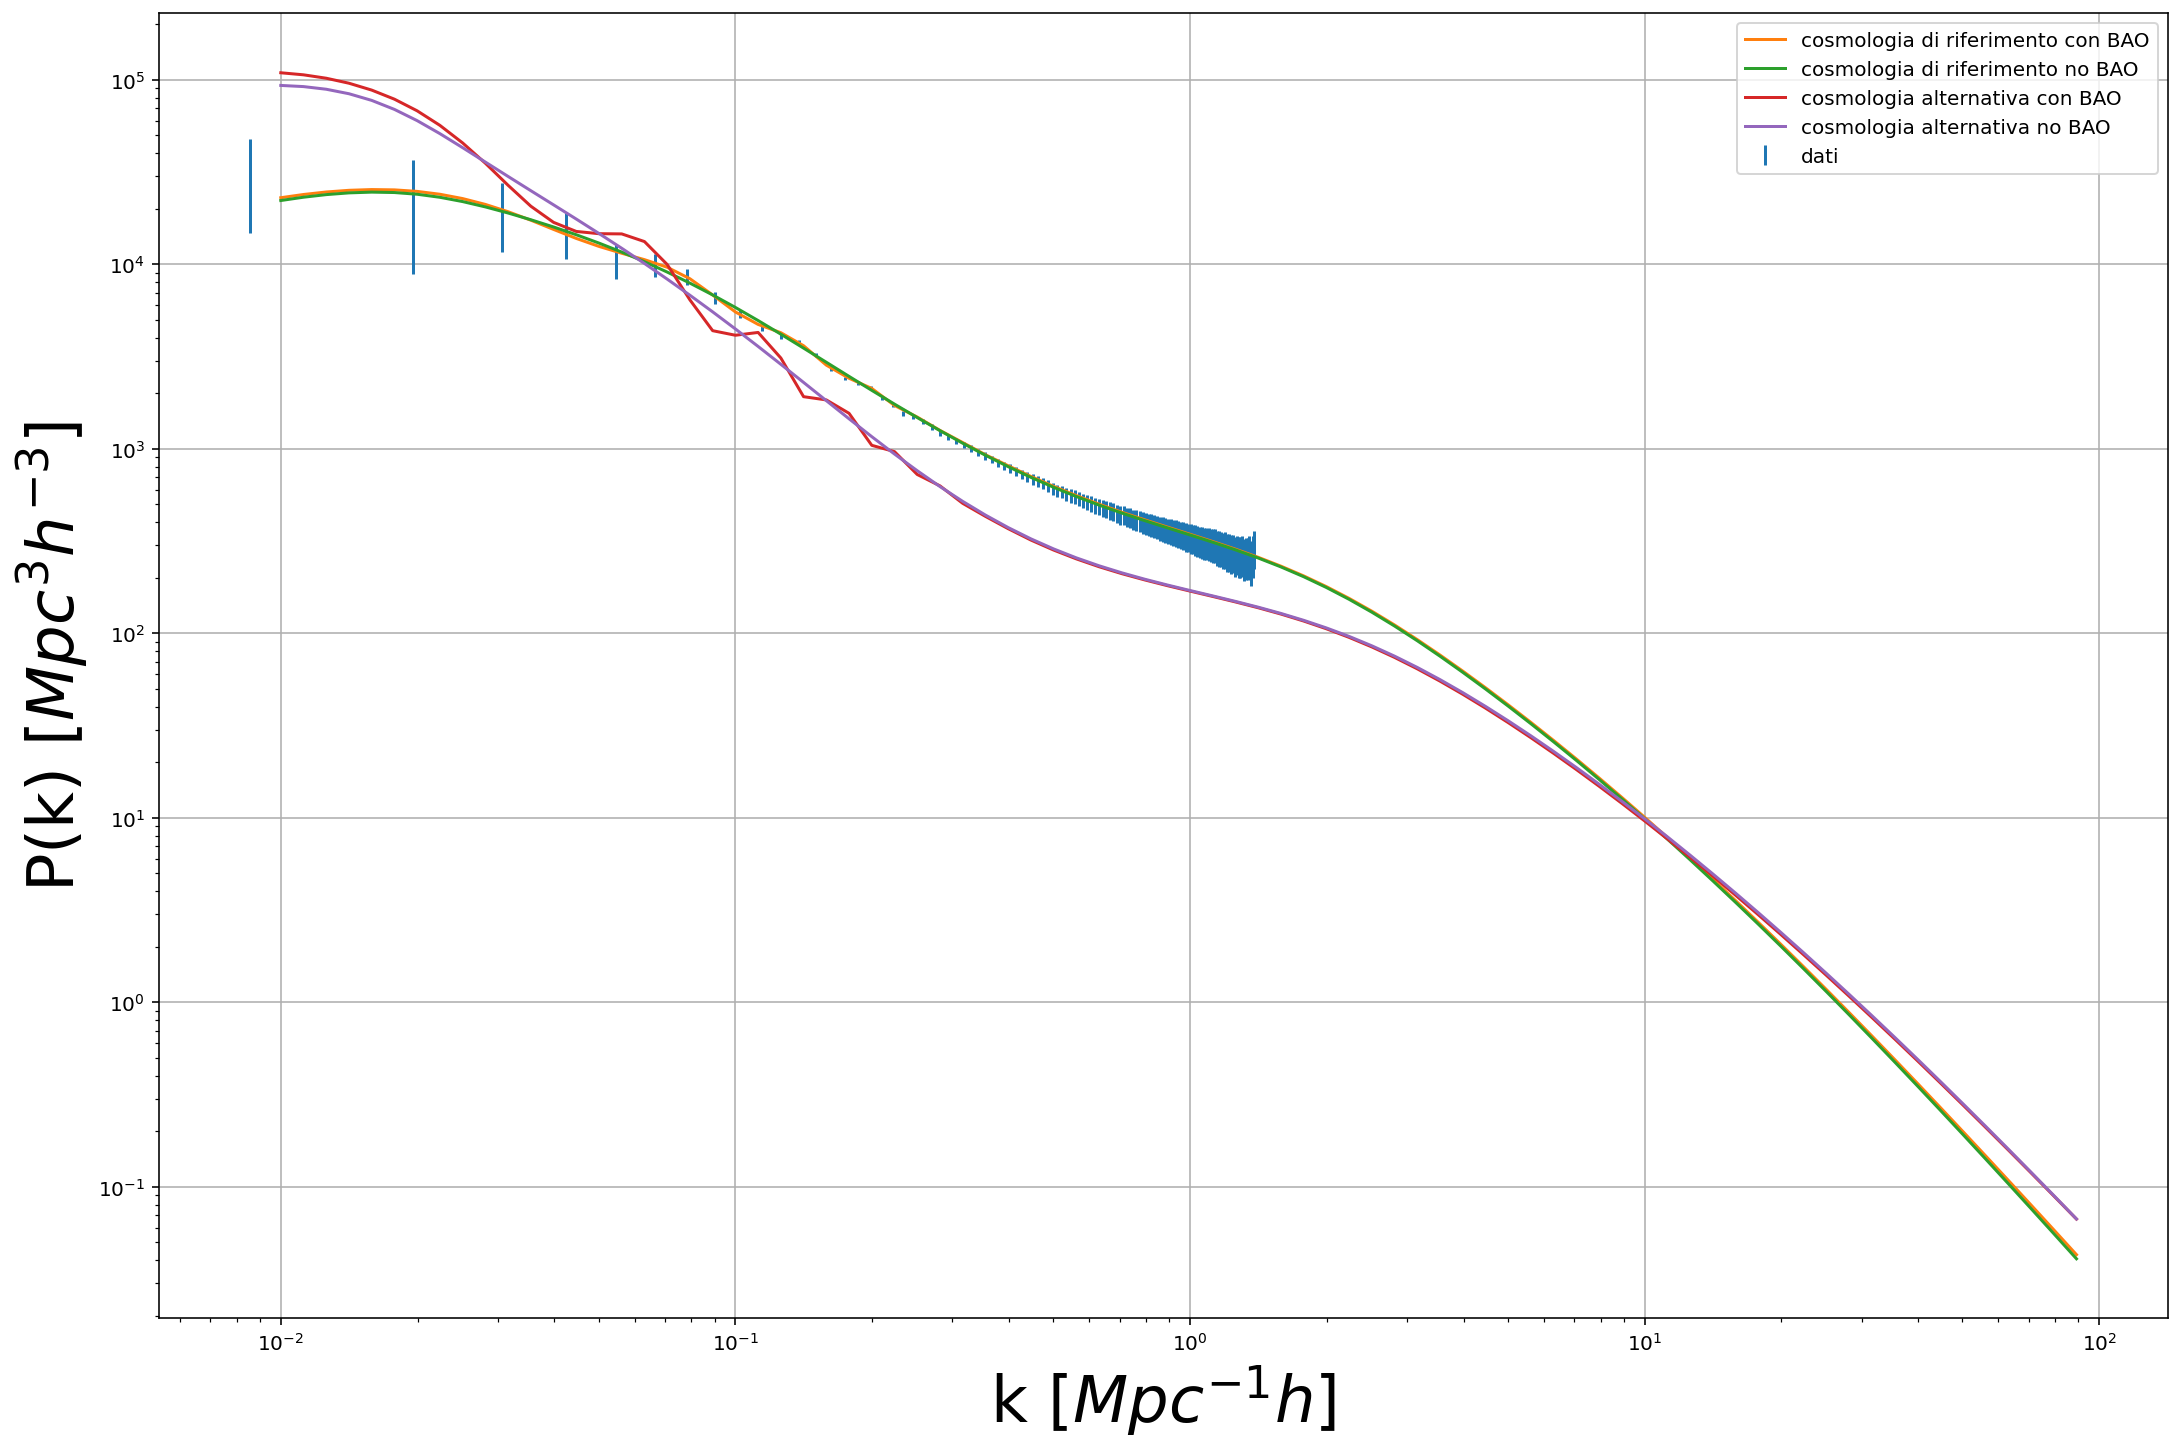

In [66]:
plt.figure(figsize=(18,12))
plt.errorbar(kbins, p_k,yerr= uncert,label='dati',ls='')

plt.loglog(hm_ref.k_hm,spettro_BAO.power_auto_matter_fnc(hm_ref.k_hm),label='cosmologia di riferimento con BAO')
plt.loglog(hm_ref.k_hm,spettro_noBAO.power_auto_matter_fnc(hm_ref.k_hm),label='cosmologia di riferimento no BAO')

plt.loglog(hm_ref.k_hm,pk_contrasto_BAO.power_auto_matter_fnc(hm_ref.k_hm),label='cosmologia alternativa con BAO')
plt.loglog(hm_ref.k_hm,pk_contrasto_noBAO.power_auto_matter_fnc(hm_ref.k_hm),label='cosmologia alternativa no BAO')

plt.xscale('log')
plt.yscale('log')
plt.xlabel("k [$Mpc^{-1} h$]",size=32)
plt.ylabel(r" P(k)$  \ [{ Mpc^3}h^{-3}]$",size=32);
plt.legend()
plt.grid()
#plt.xlim(0.008,1)

Che cosa si può dire dei vari modelli? Sono entrambi affidabili?

In [67]:
dati = p_k[cut_index_in:cut_index_fin+1]

In [68]:
incertezze = uncert[cut_index_in:cut_index_fin+1]

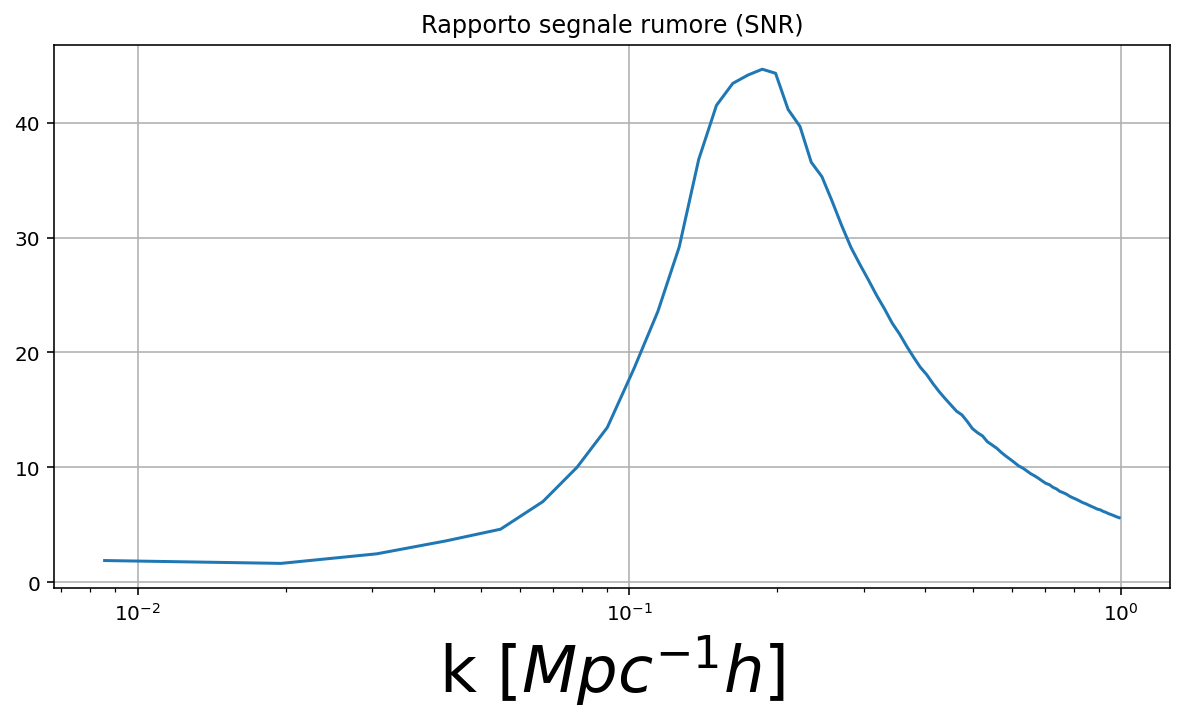

In [69]:
plt.figure(figsize=(10,5))

# Vediamo il nostro rapporto segnale rumore 
plt.title('Rapporto segnale rumore (SNR)')
plt.semilogx(kbins[cut_index_in:cut_index_fin+1],dati/incertezze)
plt.xlabel("k [$Mpc^{-1} h$]",size=32)
plt.grid()

Qui comincia il nostro fit dei dati: abbiamo le misure, abbiamo due modelli di spettro di potenza, entrambi costruiti in questo modo: assumiamo che ci sia una componente "garantita" dello spettro di potenza senza oscillazioni, $P_{no BAO}$ e ad essa aggiungiamo un termine con le oscillazioni, in questo modo:
        $$P_\text{modello} (k) = A  ( P_{BAO}(k/\alpha) - P_{no BAO}(k/\alpha) ) + P_{no BAO(k)} + B * k  $$

Allora: 
- L'ampiezza A, nel caso ideale, deve valere circa 1, in modo che poi tutti i termini senza BAO si cancellino
- Il fattore di Alcock-Paczynski $\alpha$ deve nuovamente valere circa 1, se la nostra cosmologia è affidabile.
- Il fattore B è un cosiddetto "nuisance parameter", un parametro di disturbo che aggiunge non linearità al modello. Non abbiamo assunzioni particolari sul suo valore, più è piccolo, al limite 0, più vuol dire che il nostro modello senza B riproduce correttamente la realtà, senza ulteriori correzioni necessarie.

Il fit si fa in questo modo: 

- Voglio minimizzare la distanza tra i dati (inversamente pesati per le incertezze, più è piccola l'incertezza, maggiore è l'importanza che voglio dare a quel dato per vincolare il fit) e il modello.
    - Per farlo, lascio che i parametri del modello (A, $\alpha$, B), cambino il proprio valore liberamente, partendo inizialmente in modo abbastanza casuale e poi, quando hanno trovato una "direzione" di minimizzazione della distanza, cioé, al loro variare, tutti assieme, la distanza tra dati e modello si riduce sempre più, aspetto che si stabilizzino ad un valore con piccole fluttuazioni. La distanza non aumenta né diminuisce di più, il fit è giunto a convergenza.  Questo metodo di fit non è l'unico, ne esistono di più semplici ed analitici (esistono cioè formule risolutive esatte) o più complessi, puramente numerici, come questo. Si tratta però di uno dei metodi preferiti dai cosmologi, noto come Monte Carlo Markov (cioé casuale) Chain (MCMC, dove chain, "catena", indica proprio la sequenza di passi fatta per migliorare progressivamente il fit dei dati 
    - Ripeto l'operazione per due modelli, specificati da lnlike_1 e lnlike_2, che differiscono sostanzialmente per una cosmologia. 

In [70]:
#Fit con due modelli

def lnlike_1(theta):  
    
    # Modello "vero"
    
    A, alpha , B = theta
        
    modello = np.zeros(len(k_data))  
    
    funzione_fit = lambda k:  A * ( spettro_BAO.power_auto_matter_fnc(k/alpha) - spettro_noBAO.power_auto_matter_fnc(k/alpha) ) + spettro_noBAO.power_auto_matter_fnc(k) + B * k
     
    modello = funzione_fit(k_data)
    
    scarti_su_incertezze = np.sum(( ( dati - modello) / incertezze  ) ** 2)   
        
    return -0.5 * scarti_su_incertezze
       

def lnlike_2(theta):  
    
    # Modello "di contrasto"
    
    A, alpha ,B = theta
        
        
    modello = np.zeros(len(k_data))  #monopole model
    
    funzione_fit = lambda k:  A * ( pk_contrasto_BAO.power_auto_matter_fnc(k) - pk_contrasto_noBAO.power_auto_matter_fnc(k/alpha) ) + pk_contrasto_noBAO.power_auto_matter_fnc(k) + B * k
    
        
    modello = funzione_fit(k_data)
    
    scarti_su_incertezze = np.sum(( ( dati - modello) / incertezze  ) ** 2)   
        
    return -0.5*scarti_su_incertezze
       


"Fissiamo i prior". 

Esistono due modi fondamentali per fare analisi statistiche: 
- Inferenziale: la statistica inferenziale non assume a priori alcuna proprietà dei dati, i valori più probabili e la loro distribuzione di frequenza emerge dalle misure stesse. 
- Bayesiana: l'osservatore, a partire dala propria esperienza passata, dal contesto, dal buon senso o dai limiti fisici del problema, impone alcuni vincoli ai dati a priori ("prior"), imponendo all'algoritmo di non variare i propri parametri entro quei limiti. I prior hanno diversa forma, più sono stretti e più premiano certi valori, maggiore è il grado di informazione che l'osservatore impone al problema. Se tutti i valori sono equiprobabili, e vincoliamo solo gli estremi, i prior sono uniformi (cioé, la distribuzione di probabilità è uniforme) e si parla di prior non informativi. Questa sarà la nostra scelta.  

In generale, tecniche di combinazione tra le osservabili, scelta dei prior in modo che siano vincolanti, ad esempio ricorrendo alle osservazioni di Planck della radiazione cosmica di fondo, rivestono un ruolo importantissimo nell'analisi dei dati in fisica.

In [71]:
def lnprob_1(theta):
    
    lp = lnprior_1(theta)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike_1(theta)
    
def lnprior_1(theta):
    
    A ,alpha, B = theta
    
    if 0 < A < 2 and 0. < alpha < 2 and 0 < B <1:
    
        return 0.0
    
    return -np.inf


def lnprob_2(theta):
    lp = lnprior_2(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike_2(theta)

    
def lnprior_2(theta):
    A, alpha ,B = theta
    if 0 < A < 2 and 0. < alpha < 2 and 0 < B <1:
        return 0.0
    return -np.inf

In [72]:
# Eseguiamo i nostri due fit 

import emcee # importiamo il programma che farà il lavoro per noi

nwalkers = 100 # imponiamo un certo numero di punti di partenza all'esplorazione dello spazio dei parametri
niter=10000 # imponiamo un certo numero di passi per assicurarci che la catena giunga poi effettivamente a convergenza
 # e non "si inganni" in un minimo locale provvisorio.

npars = 3 #numero di parametri

fiduc=np.array([1,1,0]) #valori fiduciari, quelli che ci aspettiamo saranno il valore di "Best fit"

ndim = len(fiduc)      

randy = fiduc + 1e-2 * np.random.randn(nwalkers,ndim) # comincia ad esplorare ad una certa distanza dal valore di partenza

pos = fiduc + randy


In [73]:
from multiprocessing import Pool # per fare prima, parallelizziamo l'operazione, distribuendola sui vari processori del 
# computer
with Pool() as pool:
    sampler_1=emcee.EnsembleSampler(nwalkers,ndim,lnprob_1,pool=pool)
    sampler_1.run_mcmc(pos, niter, progress=True);
    
   

  0%|                                                                                 | 0/10000 [00:00<?, ?it/s]/home/andrea/anaconda3/envs/progetto_1/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|████████████████████████████████████████████████████████████████████| 10000/10000 [01:29<00:00, 111.41it/s]


In [74]:
from multiprocessing import Pool
with Pool() as pool:
    sampler_2=emcee.EnsembleSampler(nwalkers,ndim,lnprob_2,pool=pool)
    sampler_2.run_mcmc(pos, niter, progress=True);

100%|████████████████████████████████████████████████████████████████████| 10000/10000 [01:29<00:00, 112.10it/s]


La Monte Carlo Markov Chain (MCMC) non fornisce **un valore** di best fit per ogni parametro (come per l'approccio inferenziale), ma una distribuzione di probabilità a posteriori (il posterior) che, di solito, è gaussiana, con un massimo ben definito che rappresenta il valore di best-fit. Ogni valore, in teoria, del posterior, è ammesso, ma il massimo è favorito in quanto più probabile. D'altra parte, non è detto che i posterior siano così gaussiani come ci aspetteremmo...

Removed no burn in


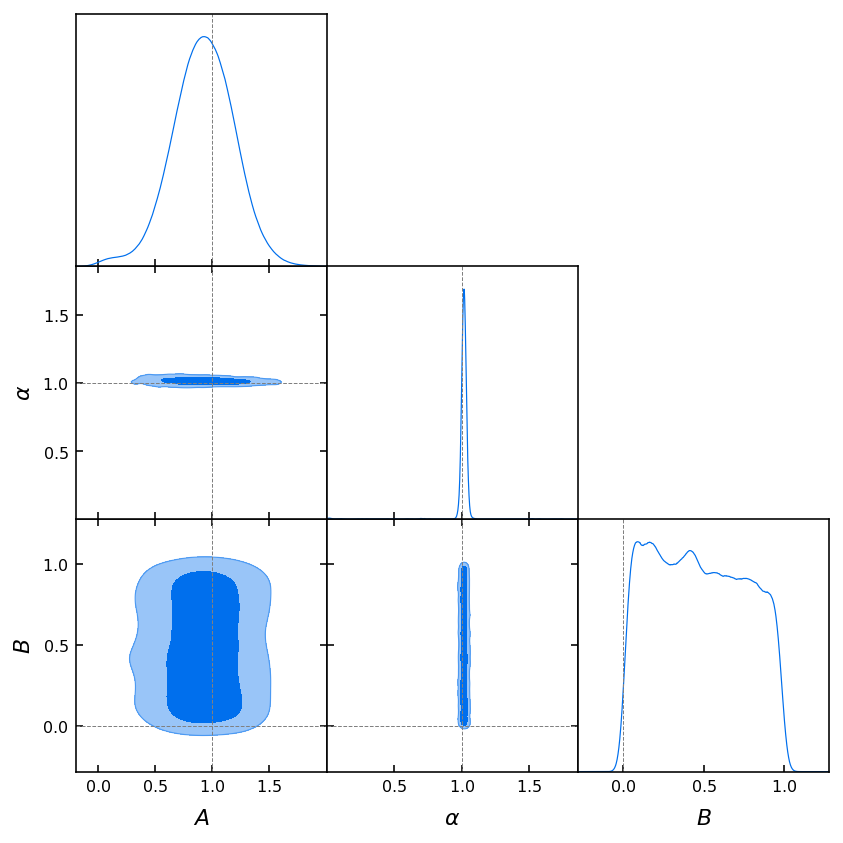

In [80]:
nburn = 400

labels = [r'A',r'\alpha','B']
flat_samples_1 = sampler_1.get_chain(discard=int(nburn*2), thin=int(0.5*nburn), flat=True)

    
        
names = ['A','alpha','B']
markers={'A':fiduc[0],r'alpha':fiduc[1],'B':fiduc[2],}
        
      
        
samples_1 = MCSamples(samples=flat_samples_1,names = names, labels = labels)
g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add=0.4
g.settings.title_limit_fontsize = 14
g.triangle_plot([samples_1], filled=True,title_limit=None,markers=markers) 

Removed no burn in


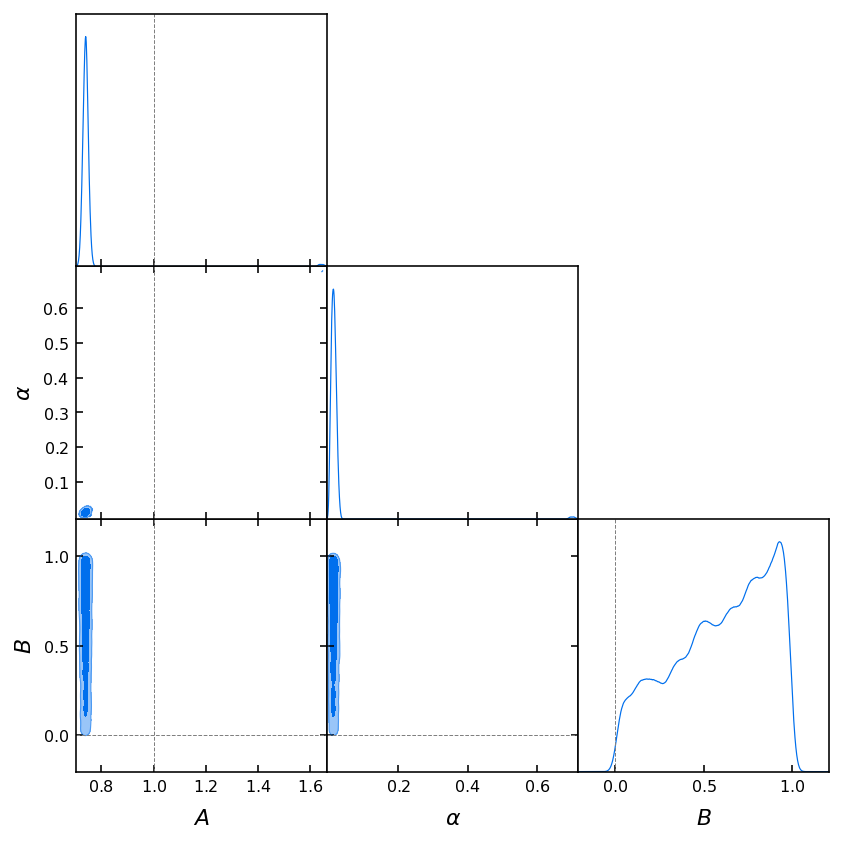

In [79]:
nburn = 400

labels = [r'A',r'\alpha','B']
flat_samples_2 = sampler_2.get_chain(discard=int(nburn*2), thin=int(0.5*nburn), flat=True)

    
        
names = ['A','alpha','B']#'npar_fid','nperp_fid']#,'k_par_quadru','k_perp_quadru']
markers={'A':fiduc[0],'alpha':fiduc[1],'B':fiduc[2],}#'npar_fid':npar_fid,'nperp_fid':nperp_fid}#,'k_par_quadru':k_par_fid_quadru/kpar0,'k_perp_quadru':k_perp_fid_quadru/kperp0}
        
#markers={bg_fid,'bh':pref_H_fid,'r':R_fid,'sigma':sigmar_fid,'k_par_mono':k_par_fid_mono/kpar0,'k_perp_mono':k_perp_fid_mono/kperp0,'k_par_quadru':k_par_fid_quadru/kpar0,'k_perp_quadru':k_perp_fid_quadru/kperp0}
       
        
samples_2 = MCSamples(samples=flat_samples_2,names = names, labels = labels)
g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add=0.4
g.settings.title_limit_fontsize = 14
g.triangle_plot([samples_2], filled=True,title_limit=None,markers=markers) 

Siamo principalmente interessati ad $\alpha$: confrontiamo tra i due risultati e proviamo a commentarli

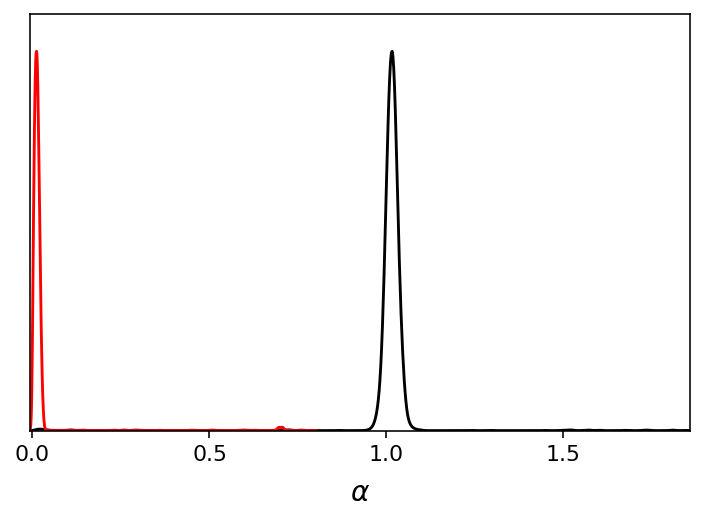

In [81]:
# 1D marginalized comparison plot
g = plots.get_single_plotter(width_inch=5)
g.plot_1d([samples_1, samples_2], 'alpha',texstize=30)

Che cosa ci dicono questi parametri? Sono compatibili? Sono in tensione?

In [82]:
from IPython.display import display, Math
sample1=np.zeros(len(fiduc))
uncert_par_1=np.zeros([ndim,2])  #store +- uncertainties
        
for i in range(ndim):
    mcmc = np.percentile(flat_samples_1[:, i], [16, 50, 84]) #best-fit value =50th percentile
    sample1[i]=mcmc[1]#round(mcmc[1], 2) samples.means[i]
    q = np.diff(mcmc)
    uncert_par_1[i]=q
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))
        

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [83]:
sample2=np.zeros(len(fiduc))
uncert_par_2=np.zeros([ndim,2])  #store +- uncertainties
        
for i in range(ndim):
    mcmc = np.percentile(flat_samples_2[:, i], [16, 50, 84]) #best-fit value =50th percentile
    sample2[i]=mcmc[1]#round(mcmc[1], 2) samples.means[i]
    q = np.diff(mcmc)
    uncert_par_2[i]=q
    q = np.diff(mcmc)
    print(q)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))
    
        

[0.01 0.01]


<IPython.core.display.Math object>

[0.007 0.008]


<IPython.core.display.Math object>

[0.367 0.258]


<IPython.core.display.Math object>

$\alpha$, specialmente il secondo, non è molto gaussiano, le due incertezze non sono molto simmetriche. Assumiamo che valga l'incertezza maggiore, e calcoliamo allora questa quantità $\dfrac{ \alpha_1 - \alpha_2 }{ \sqrt{ \sigma_{1}^2 + \sigma_{2}^2 }} $
       
Che ci dice quanto, e se, i due parametri sono in tensione.

In [84]:
(sample1[1]-sample2[1])/np.sqrt(np.min(uncert_par_1[1])**2 + np.min(uncert_par_2[1])**2) # rivedere, ho un po' "adattato"

53.69724622820244

I due parametri sono in tensione a 53 $\sigma$, decisamente incompatibili!
Ma a sua volta, il risultato sarà compatibile con la cosmologia fiduciaria, potremo dire che $\alpha$ vale 1 entro le incertezze?

In [85]:
(sample1[1]-1)/np.sqrt(np.max(uncert_par_1[1])**2)

0.9697161459348516

Sì, perché la differenza è di circa 1 sigma (non un fit perfetto, sicuramente) ma minore dei tipici criteri di 3 o 5 sigma adottati in fisica per stabilire la significatività di una differenza, o di una compatibilità, tra i dati e il modello.

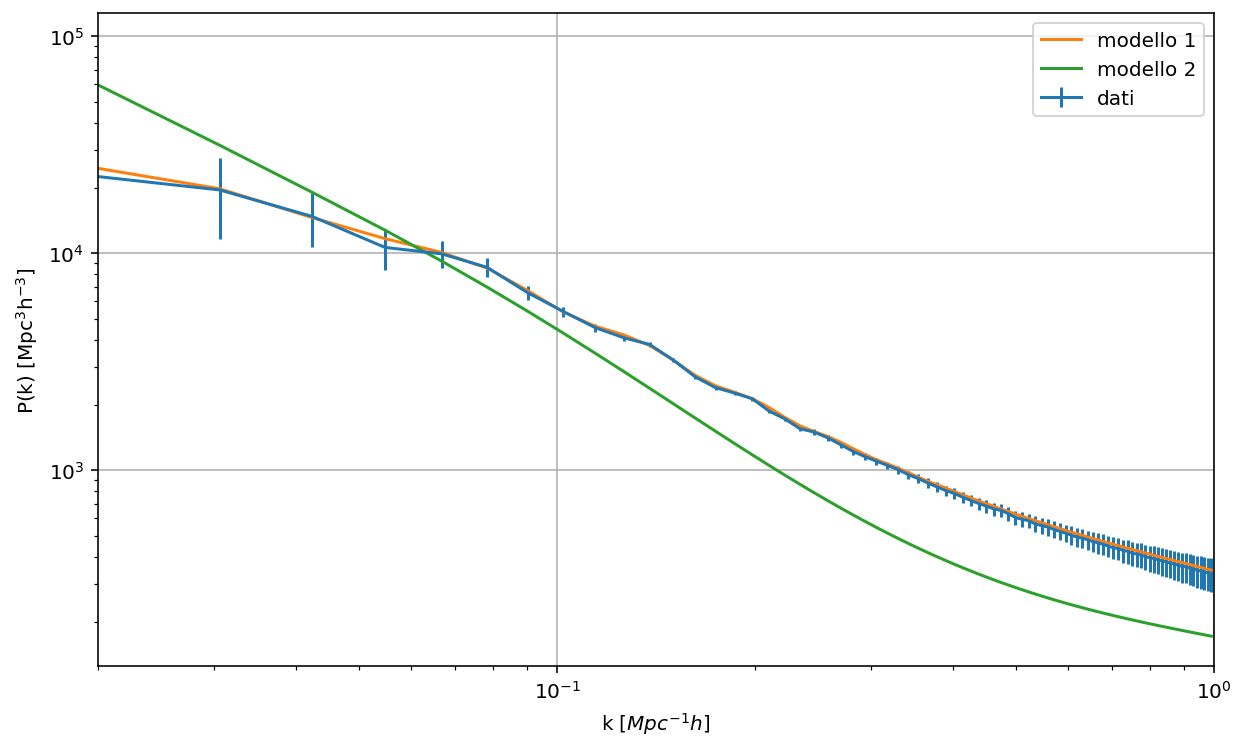

In [86]:
# Confrontiamo i due risultati

funzione_fit_1 = lambda k:  sample1[0] * ( spettro_BAO.power_auto_matter_fnc(k/sample1[1]) - spettro_noBAO.power_auto_matter_fnc(k/sample1[1]) ) + spettro_noBAO.power_auto_matter_fnc(k) + sample1[2] * k
funzione_fit_2 = lambda k:  sample2[0] * ( pk_contrasto_BAO.power_auto_matter_fnc(k/sample2[1]) - pk_contrasto_noBAO.power_auto_matter_fnc(k/sample2[1]) ) + pk_contrasto_noBAO.power_auto_matter_fnc(k) + sample2[2] * k
    

plt.figure(figsize=(10,6))     
plt.errorbar(k_data, dati,yerr= incertezze,label='dati')
#plt.loglog(hm.k_hm,P_nwh(hm.k_hm))
#plt.loglog(hm.k_hm,P_wh(hm.k_hm))

plt.loglog(k_data,funzione_fit_1(k_data),label='modello 1')
plt.loglog(k_data,funzione_fit_2(k_data),label='modello 2')

plt.xscale('log')
plt.yscale('log')
plt.legend()

plt.xlabel("k [$Mpc^{-1} h$]")
plt.ylabel(r"$\rm P(k) \ [{\rm Mpc^3}h^{-3}]$");
plt.xlim(2*1e-2,1)
plt.grid()

## Bibliografia

### Testi di ordine generale

- Corrado Lamberti *Capire l'universo. L'appasionante avventura intellettuale della cosmologia*, Springer Verlag, 2011: un bellissimo e validissimo testo introduttivo, consigliatissimo per avvicinarsi alla materia coprendo tutti gli argomenti fondamentali.
- Mike Inglis, *L'astrofisica è facile*, Springer Verlag, 2009. Un utile contraltare al precedente, per acquisire diverse nozioni fondamentali di astrofisica, utili anche per il cosmologo.
- Roger Penrose, *La strada che porta alla realtà*, Bur, 2018 (seconda ed.); un libro-manuale che introduce a tutto quanto un appassionato deve conoscere per capire almeno il *significato*, se non la pratica, del linguaggio matematico e concettuale retrostante la fisica moderna. La discussione sulla cosmologia è un po' datata, molto legata alle opinioni personali dell'autore e non particolarmente estesa, ma la referenza è imprescindibile per chiunque ami la fisica e voglia provare a capirla nello stesso senso in cui un appassionato d'arte può apprezzare un'opera andando oltre l'immagine, guardando alla tecnica, un appassionato di musica educa il proprio orecchio con nozioni di armonia e composizione, o un appassionato di storia impara una lingua antica per tornare direttamente alle fonti

### Storia della cosmologia fisica:

- John Richard Gott, *La ragnatela cosmica*, Bollati Boringhieri, 2016: un racconto della cosmologia tra gli anni '60 e la contemporaneità, che riassume gli sforzi dei pionieri delle simulazioni e dello studio del clustering, da Peebles a Einasto, revisionando il progressivo imporsi del modello $\Lambda$CDM, tra materia oscura ed energia oscura. Un libro che, per quanto mi riguarda, richiede una rilettura, che apprezzo di più a posteriori, nella memoria, man mano che i miei studi si sono addentrati nella ragnatela cosmica.
- Paul Halpern, *Flashes of creation*, Basic Books, 2021. Non disponibile in italiano, se il libro di Gott è la storia del regime perturbativo, il libro di Halpern è la storia di come è stato modellato il background, scontro di modelli cosmologici, personalità e visioni scientifiche e filosofiche del mondo talvolta molto diverse, come il contrasto tra Fred Hoyle, George Gamow e Georges Lemaître, pionieri dei temi fondamentali della cosmologia odierna: Big Bang, radiazione cosmica di fondo, espansione dell'universo. 
- Steven Weinberg, *I primi tre minuti*, un grande classico sulla storia dell'universo, il cui titolo è ispirato ai primi istanti dell'universo: è infatti nei primi tre minuti dopo il Big Bang che si formano i nuclei di idrogeno, elio e litio precurso di tutta la materia di cui siamo fatti, tre minuti di nucleosintesi primordiale che condizionano i successivi tredici miliardi di anni di storia dell'universo, l'esistenza e l'esperienza umana e di ogni altra creatura sulla terra. Una incredibili sproporzione tra un orizzonte di tempo così grande e un intervallo temporale così intuitivo per un essere umano e incredibilmente significativi per l'intero universo.  


### Per chi vuole divertirsi tra scienza e letteratura

- Italo Calvino, *Le cosmicomiche*, Einaudi, 2022: la raccolta per eccellenza della letteratura italiana in cui la scienza si fa racconto, fantasmagoria, metafora brillante, poesia ma anche parabola ironica ed immaginifica. Scritti negli anni '60, quando i temi del Big Bang stavano cominciando ad imporsi nella divulgazione e nel dibattito pubblico, i racconti di scienza sono di fatto racconti di cosmogonia, che passo dopo passo riassumono la storia dell'universo, a partire dall'istante iniziale, "Ti-con-zero", quando l'universo era "tutto in un punto". 
- Piero Boitani, *Il grande racconto delle stelle*, Il Mulino, 2019. Una meravigliosa, completissima sia nell'enciclopedismo letterario che nella selezione iconografica, storia culturale e letteraria della fascinazione dell'uomo per il cielo stellato, tra astronomia, cosmologia, cosmogonie di ogni luogo e tempo, fino alle fantasmagorie postmoderne più che mai impregnate di scienza. 
- E, collegato al libro di Boitani: la cosmogonia del Timeo di Platone, e qualunque cosmogonia di ogni civiltà mai apparsa sulla faccia della terra. Perché, in fin dei conti, le domande che ci muovono sono le stesse dei nostri antenati, che guardando al cielo stellato si interrogavano su come si fosse originato lo spettacolo dell'universo. E se, seduti ai loro focolari, i loro bardi e cantori hanno intessuto mitologie, non vogliamo anche noi godere ancora un poco del brivido del mistero, parlando di materia ed energia oscure?

### Materiali per chi volesse approfondire gli aspetti scientifici (testi di livello universitario).

- Peter Collier, *A most incomprehensible thing*: introduzione alla relatività generale, autopubblicata su Amazon, comprensiva di cosmologia. Molto interessante, tra il qualitativo ed il qualitativo, introduzione ben fatta per appassionati che, come nel caso del libro di Penrose, desiderino impadronirsi delle basi del linguaggio matematico della relatività generale, "leggere le formule" e capire come sono fatte, che cosa significhino e quali siano le incognite delle equazioni che i fisici vogliono misurare.
- Edward W. Kolb, Michael S. Turner, *The Early Universe*, anche in questo caso disponibile su Amazon come ristampa, solo in inglese. Dall'universo omogeneo alle basi della cosmologia quantistica, un testo fondamentale specialmente per capire l'evoluzione dell'universo nella sua fase primordiale e "calda", quando vengono sintetizzati gli elementi costitutivi della materia che conosciamo (bariogenesi e nucleosintesi primordiale), che copre però anche molto bene la teoria delle perturbazioni e la formazione delle strutture. 
- Attilio Ferrari, *Stelle, Galassie e Universo. Fondamenti di Astrofisica*, Springer Verlag, 2011. Manuale universitario di astrofisica e cosmologia (con utile appendice online anche da scaricare), redatto da uno dei più importanti docenti di astrofisica dell'Università di Torino, radioastronomo di formazione, attento alla divulgazione e a lungo presidente del Planetario e Museo dello spazio di Torino, nonché direttore dell'osservatorio astronomico di Pino Torinese.
- John Peacock, *Cosmological Physics*, Cambridge University Press, 1998. Manuale universitario, copre in realtà molto di più della cosmologia (ma, d'altra parte, la cosmologia è per definizione una branca in cui tutta la conoscenza accumulata dalla fisica nel tempo diventa in qualche modo necessaria) di quanto il titolo lasci intuire, dalla relatività generale alla teoria dei campi all'astrofisica. Ha un taglio un po' datato, più astrofisico e meno statistico, ma proprio per questo può aiutare a cogliere il senso "osservativo" di certi concetti.  
- Scott Dodelson, Fabian Schmidt, *Modern Cosmology*, 2020. Semplicemente IL MANUALE di cosmologia, per impararne davvero il linguaggio contemporaneo, basato sulla teoria perturbativa e l'inferenza bayesiana. Esiste anche una prima edizione, ancora disponibile pubblicata nel 2003. Un poco datata, non altrettanto onnicomprensiva, ma validissima allo stesso modo. Si tratta di un saggio universitario gradevole, ma richiede già una preparazione avanzata, è oggetivamente difficile per un liceale curioso. Per chi desiderasse capire "come funziona" la cosmologia, a cavallo tra quantitativo e qualitativo, i testi precedenti restano quelli consigliati. 

- Note di Alessandro Marconi per il corso di Cosmologia all'Università di Firenze. Si tratta di un valido [manuale di cosmologia in italiano](https://drive.google.com/file/d/1Hv35YdAvKbJnJLfLbGYE2xAV9bejKfZ4/view?usp=drive_link)
che copre tutto quanto è necessario sapere per avere una formazione sull'argomento, dall'espansione dell'universo alla CMB. Ha un taglio più vicino al Peacock che al Dodelson, lievemente più statistico che astrofisico, ma sicuramente tra i migliori testi di riferimento a disposizione in italiano. Ci sono spiegazioni "in prosa", grafici ed altri materiali utili anche per un liceale, se queste lezioni hanno suscitato passione ed interesse per l'argomento, magari un giorno tornerà utile. 

- [L'articolo di Jim Peebles, Premio Nobel per la Fisica nel 2019 per i suoi lavori fondamentali e pionieristici in cosmologia](https://arxiv.org/pdf/2208.05018.pdf) che revisiona gran parte dei problemi aperti al 2022 nella disciplina, oltre alle tensioni più note come quella sulla costante di Hubble.


## Link per capire meglio le proprietà della trasformata di Fourier (in inglese)

- https://optometry.berkeley.edu/the-spatiotemporal-power-spectrum-of-natural-human-vision/
- https://plus.maths.org/content/fourier-transforms-images#:~:text=The%20Fourier%20transform%20is%20represented,dimensional%20space%20of%20the%20image
- https://homepages.inf.ed.ac.uk/rbf/HIPR2/fourier.htm#:~:text=The%20Fourier%20Transform%20is%20an,is%20the%20spatial%20domain%20equivalent
- https://help.heartmath.com/v1/en/power_spectrum.html